In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import geopandas as gpd
import random
from scipy.stats import truncnorm, norm
from collections import defaultdict
import math
from shapely.ops import transform
from pyproj import Geod
import pyarrow
import dill
from datetime import datetime
import sys
import importlib
from dataclasses import dataclass

In [2]:
# добавляем папку modules в sys.path, чтобы импортировать функции созданные ранее

sys.path.append(os.path.abspath(os.path.join("..", "modules")))

In [3]:
# Функции генерации паттернов времени и базовые функции времени созданные ранее

from data_generator.general_time import *
from data_generator.utils import build_transaction
from data_generator.fraud import FraudTransPartialData

In [15]:
# Функции сохранения и загрузки сессии (сохранять и загружать переменные, функции и т.д.)

# import session.session_handler as session_h
# importlib.reload(session_h)

In [4]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)

In [5]:
os.getcwd()

'C:\\Users\\iaros\\My_documents\\Education\\projects\\fraud_detection_01\\notebooks'

In [6]:
os.chdir("..")

In [7]:
os.getcwd()

'C:\\Users\\iaros\\My_documents\\Education\\projects\\fraud_detection_01'

# Доп. данные для генерации фрод транзакций

**Загрузка данных:**
- оффлайн мерчантов
- онлайн мерчантов
- девайсов клиентов и мошенников
- городов с полигонами
- городов с координатами центров
- клиентов
- фрод IP адресов
- категорий и их характеристик

In [23]:
offline_merchants = gpd.read_file("./data/cleaned_data/offline_merchants_points.gpkg")
online_merchant_ids = pd.read_csv("./data/cleaned_data/online_merchant_ids.csv").iloc[:, 0]
client_devices = pd.read_csv("./data/cleaned_data/client_devices.csv")
fraud_devices = pd.read_csv("./data/cleaned_data/fraud_devices.csv")
districts_ru = gpd.read_file("./data/cleaned_data/district_ru.gpkg")
area_centers = gpd.read_file("./data/cleaned_data/area_centers.gpkg")
clients_with_geo = gpd.read_file("./data/cleaned_data/clients_with_geo.gpkg") 
fraud_ips = gpd.read_file("./data/cleaned_data/fraud_ips.gpkg")
cat_stats_full = pd.read_csv("./data/cleaned_data/cat_stats_full.csv")

# Генерация времени

**Датафрейм под транзакции. Этап тестов**<br>
Создадим пустой датафрейм под транзакции. Будем копировать и использовать его при тестах функций.

In [24]:
transactions = pd.DataFrame(
            {"client_id": pd.Series(dtype="int64"),
            "txn_time": pd.Series(dtype="datetime64[ns]"),
             "unix_time":pd.Series(dtype="int64"),
            "amount": pd.Series(dtype="float64"),
            "type": pd.Series(dtype="string"),
            "channel": pd.Series(dtype="string"),
            "category": pd.Series(dtype="string"),
            "online":pd.Series(dtype="bool"),
            "merchant_id":pd.Series(dtype="int64"),
             "trans_city":pd.Series(dtype="string"),
            "trans_lat":pd.Series(dtype="float64"),
             "trans_lon":pd.Series(dtype="float64"),
            "trans_ip":pd.Series(dtype="string"),
             "device_id":pd.Series(dtype="int64"),
             "account": pd.Series(dtype="int64"),
            "is_fraud": pd.Series(dtype="bool"),
             "is_suspicious": pd.Series(dtype="bool"),
            "status":pd.Series(dtype="string"),
            "rule":pd.Series(dtype="string")})
transactions

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule


## Подфункция генерации времени для фрод кейсов `fast_geo_change` и `fast_geo_change_online`

In [25]:
def generate_time_fast_geo_jump(last_txn_unix, geo_distance, threshold=800):
        """
        Генерация времени с коротким интервалом от предыдущей транзакции, для имитации быстрой смены геопозиции
        ---------------------------------------------------------------------
        last_txn_unix - время последней транзакции в unix формате в секундах.
        geo_distance - кратчайшая дистанция между точками координат последней и текущей транзакции - в километрах.
                       Точки между координатами берутся при генерации транзакции. Домашний город клиента и любой другой город, кроме домашнего.
        threshold - порог скорости перемещения между точками в км/ч. Все что быстрее - фрод.
                    Это нужно чтобы генерировать соответствующее время в зависимости от дистанции между точками транзакций.
                    Быстрая скорость - маленькое время между транзакциями в плане возможностей перемещения на расстояние.
        ---------------------------------------------------------------------
        Возвращает pd.Timestamp и unix время в секундах.
        """

        # Случайно сгенерированная фактическая скорость превышающая легитимный порог. Допустим от 801 до 36000 км/ч
        # до 36000 км/ч т.к. грубо говоря транзакция может быть совершена через 20 минут в 9000 км от предыдущей т.е. как-будто бы скорость 36000 км/ч
        # 9000 км взяты как весьма примерное, самое длинное возможное расстояние между городами России при путешествии самолетом.
        # но в зависимости от расстояния мы берем разные границы для распределений, чтобы не было перекоса в очень быстрое время. 
        # Также 20 минут я случайно взял как средний интервал для подобной фрод транзакции.
        # Конечно же "скорость перемещения" может быть и больше в реальной жизни
        
        if geo_distance < 1000:
            fact_speed = np.random.uniform(threshold + 1, 3000)
        elif geo_distance >= 1000 and geo_distance <= 3000:
            fact_speed = np.random.uniform(threshold + 1, 9000)
        elif geo_distance > 3000 and geo_distance <= 6000:
            fact_speed = np.random.uniform(threshold + 1, 18000)
        else:
            fact_speed = np.random.uniform(threshold + 1, 36000)
        
        # Делим полученную скорость на 3.6 для перевода в м/с - для расчета времени в секундах
        # т.к. будет добавлять к unix времени предыдущей транзакции
        fact_speed /= 3.6

        # переводим дистанцию в метры
        geo_distance = geo_distance * 1000
    
        # интервал времени между последней транзакцией и текущей фрод транзакцией в секундах
        time_interval = geo_distance / fact_speed
        
        txn_unix = round(last_txn_unix + time_interval)
        txn_time = pd.to_datetime(txn_unix, unit="s")

        return txn_time, txn_unix

In [59]:
# Тест generate_time_fast_geo_jump()

# distances = pd.DataFrame({"distance":[800]*10 + [1200]*10 + [5000]*10 + [7500]*10})
# distances["minutes"] = 0

# for row in distances.itertuples():
#     minutes, _, _ = generate_time_fast_geo_jump(last_txn_unix=last_unix, geo_distance=row.distance, threshold=800)
#     distances.loc[row.Index, "minutes"] = minutes

# distances.groupby("distance").minutes.mean()

In [60]:
# for dist in list(np.arange(0, 9000, 0.1)):
#     generate_time_fast_geo_jump(last_txn_unix=last_unix, geo_distance=dist, threshold=800)


## Подфункция генерации времени транзакции для правила `trans_freq_increase` - упрощенная
- несколько частых транзакций подряд

In [26]:
def gen_time_for_frequent_trans(last_txn_time, last_txn_unix, freq_low=1, freq_high=5, test=False):
    """
    Функция для имитации времени нескольких частых транзакций подряд.
    -------------------------------------------------
    last_txn_time - pd.Timestamp последней транзакции
    last_txn_unix - unix время последней транзакции в секундах
    freq_low - int. минимальный разрыв между транзакциями в цепочке транзакций, в минутах
    freq_high - int. максимальный разрыв между транзакциями в цепочке транзакций, в минутах
    test - True или False. Тестируем мы функцию или нет.
    --------------------------------------------------
    При test == False возвращает pd.Timestamp и unix time в секундах
    При test == True возвращает pd.Timestamp, unix time в секундах и получившуюся разницу времени
    с предыдущей транзакцией в минутах в виде int
    """

    
    # частота фрод транзакций. от 1 до 5 минут. Выразим в секундах для удобства расчетов
    freq = random.randint(freq_low, freq_high) * 60
    txn_unix = last_txn_unix + freq
    txn_time = pd.to_datetime(txn_unix, unit="s")

    if not test:
        return txn_time, txn_unix
    
    else:
        return txn_time, txn_unix, freq

**Тест `gen_time_for_frequent_trans` в цикле**

In [30]:
# Датафрейм с последней транзакцией - перезапустить ячейку для теста ниже
last_time = pd.to_datetime("2023-09-20 09:14:00", format="%Y-%m-%d %H:%M:%S")
last_unix = pd_timestamp_to_unix(last_time)

trans_test_freq_time = transactions.copy().loc[:, ['txn_time', 'unix_time','online','account', 'is_fraud', 'is_suspicious']]
trans_test_freq_time.loc[0, ["txn_time","unix_time"]] = last_time, last_unix
print(f"last_time, last_unix: {last_time, last_unix}")
trans_test_freq_time

last_time, last_unix: (Timestamp('2023-09-20 09:14:00'), 1695201240)


,txn_time,unix_time,online,account,is_fraud,is_suspicious
0,2023-09-20 09:14:00,1.695201e+09,NaN,NaN,NaN,NaN


In [31]:
trans_freq_temp_df = transactions.copy().loc[:, ['txn_time', 'unix_time','online','account', 'is_fraud', 'is_suspicious']]
last_time = trans_test_freq_time.at[trans_test_freq_time.unix_time.idxmax(), "txn_time"]
last_unix = pd_timestamp_to_unix(last_time)
freq_values = []


for i in range(1,6):
    txn_time, txn_unix, freq = gen_time_for_frequent_trans(last_txn_time=last_time, last_txn_unix=last_unix, freq_low=1, freq_high=5, test=True)
    freq_values.append(freq / 60)
        
    trans_freq_temp_df.loc[i, "txn_time"] = txn_time
    trans_freq_temp_df.loc[i, "unix_time"] = txn_unix
    trans_freq_temp_df.loc[i, "is_fraud"] = True

    
    last_time = txn_time
    last_unix = txn_unix

# средняя частота фрод транзакций - всех, кроме первой фрод транзакции
print("\n\n Mean freq: ",pd.Series(freq_values).mean(), " minutes\n\n")

# к последней легальной транзакции присоединяем сгенерированные частые транзакции
trans_test_freq_time = pd.concat([trans_test_freq_time, trans_freq_temp_df])
# разница во времени с предыдущей транзакцией, в минутах
trans_test_freq_time["time_diff"] = trans_test_freq_time.unix_time.sub(trans_test_freq_time.unix_time.shift(1)) / 60
trans_test_freq_time



 Mean freq:  2.2  minutes




,txn_time,unix_time,online,account,is_fraud,is_suspicious,time_diff
0,2023-09-20 09:14:00,1.695201e+09,NaN,NaN,NaN,NaN,NaN
1,2023-09-20 09:17:00,1.695201e+09,NaN,NaN,True,NaN,3.0
2,2023-09-20 09:22:00,1.695202e+09,NaN,NaN,True,NaN,5.0
3,2023-09-20 09:23:00,1.695202e+09,NaN,NaN,True,NaN,1.0
4,2023-09-20 09:24:00,1.695202e+09,NaN,NaN,True,NaN,1.0
5,2023-09-20 09:25:00,1.695202e+09,NaN,NaN,True,NaN,1.0


**Функция получения случайных значений из `truncnorm` распределения**
- пойдет в модуль `utils`

In [33]:
def get_values_from_truncnorm(low_bound, high_bound, mean, std, size=1):
    """
    Сгенерировать массив чисел из обрезанного нормального распределения.
    Можно сгенерировать массив с одним числом
    ------------
    low_bound - float, int. Нижняя граница значений
    high_bound - float, int. Верхняя граница значений 
    mean - float, int. Среднее
    std - float, int. Стандартное отклонение
    size - Количество чисел в возвращаемом массиве
    ------------
    Возвращает np.ndarray
    """
    return truncnorm.rvs((low_bound - mean) / std, (high_bound - mean) / std, loc=mean, scale=std, size=size)

## Подфункция генерации времени c прибавлением к времени последней транзакции `derive_from_last_time`

In [213]:
def derive_from_last_time(last_txn_unix, lag_interval, min, max, random_lag=False, geo_distance=0, threshold=800):
    """
    Создать время основываясь на времени последней транзакции.
    Либо на основании гео дистанции между транзакциями либо на основании заданного лага по времени.
    Для гео надо ввести geo_distance. Для лага, НЕ вводить geo_distance, ввести lag_interval
    ---------------
    last_txn_unix - int. Unix время последней транзакции в секундах.
    lag_interval - int. Желаемый лаг по времени от последней транзакции в минутах.
    min - int. Минуты. Минимальное значение если нужен случайный лаг по времени. Выставляется когда random_lag - True
    max - int. Минуты. Максимальное значение если нужен случайный лаг по времени. Выставляется когда random_lag - True
    random_lag - bool. Должно ли значение лага быть случайным. Берется по равномерному распределению.
    geo_distance - int. Расстояние между координатами текущей и последней транзакции в километрах.
    threshold - int. Максимальная допустимая скорость перемещения км/ч между совершением транзакций,
                     для случаев когда расстояние больше 500 километров.
    ---------------
    Возвращает unix время в секундах
    """
    # Перевод в секунды для расчетов
    lag_interval = lag_interval * 60

    if random_lag:
        lag_interval = np.random.randint(min, max) * 60

    if geo_distance == 0:
        txn_unix = last_txn_unix + lag_interval
        txn_time = pd.to_datetime(txn_unix, unit="s")
        return txn_time, txn_unix
    
    if geo_distance <= 500:
        mean = 90
        std = 20
        speed = get_values_from_truncnorm(low_bound=50, high_bound=120, mean=mean, std=std).astype("int")[0]
        # Расчет добавления времени и перевод в секунды
        lag_interval = round((geo_distance / speed) * 3600)

    elif geo_distance > 500:
        mean = 300
        std = 200
        speed = get_values_from_truncnorm(low_bound=50, high_bound=threshold, mean=mean, std=std).astype("int")[0]
        # Расчет добавления времени и перевод в секунды
        lag_interval = round((geo_distance / speed) * 3600)

    txn_unix = last_txn_unix + lag_interval
    txn_time = pd.to_datetime(txn_unix, unit="s")
        
    return txn_time, txn_unix

In [211]:
derive_last = pd_timestamp_to_unix(pd.to_datetime("2025-06-20 11:57:12", format="%Y-%m-%d %H:%M:%S"))
derive_last
# pd.to_datetime(derive_last, unit="s")

1750420632

In [214]:
derive_from_last_time(last_txn_unix=derive_last, lag_interval=0, min=30, max=60, random_lag=True)

(Timestamp('2025-06-20 12:43:12'), 1750423392)

# Функция `get_time_fraud_txn` - `рефактор 3.0`

In [215]:
def get_time_fraud_txn(trans_df, time_weights, timestamps, round_clock, online=None, \
                           rule=None, geo_distance=None, lag=None, threshold=800):
    """
    Создать время для генерируемой фрод транзакции
    ---------------------------------------
    trans_df - датафрейм с транзакциями текущего клиента. Откуда брать информацию по предыдущим транзакциям клиента
    time_weights - датафрейм с весами часов в периоде времени
    timestamps - датафрейм с timestamps
    round_clock - boolean. Круглосуточная или дневная категория.
    online - boolean. Онлайн или оффлайн покупка. True or False
    rule - str. Название антифрод правила
    geo_distance - int. Дистанция между локацией последней и текущей транзакции если фрод со сменой геолокации - в километрах
    lag - boolean. Задержка по времени от предыдущей транзакции. Нужна для моделирования увеличения частоты транзакций.
          Это задержка именно между последней легитимной транзакцией и серией частых фрод транзакций. Подразумевается что функция
          get_time_for_trans будет использована в цикле, и для первой итерации lag будет True.
    threshold - int. Максимальная скорость перемещения между совершением транзакций км/ч.
                     Фрод с быстрой сменой гео будет превышать этот порог.
    ---------------------------------------------
    Возвращает время для генерируемой транзакции в виде pd.Timestamp и в виде unix времени
    """
    
    # Время последней транзакции клиента. pd.Timestamp и unix в секундах
    last_txn_time = trans_df.txn_time.max()
    last_txn_unix = trans_df.unix_time.max()

    # Правила: другая гео за короткое время либо по локации оффлайн мерчанта либо по новому ip адресу
    if rule in ["fast_geo_change", "fast_geo_change_online"]:
        return generate_time_fast_geo_jump(last_txn_unix=last_txn_unix, geo_distance=geo_distance, threshold=threshold)
    
    # Если это не первая фрод транзакция в серии частых транзакций для правила trans_freq_increase
    # Для первой транзакции в серии (lag==True) время будет создано прибавлением интервала к последней транзакции клиента
    elif rule == "trans_freq_increase" and not lag:
        return gen_time_for_frequent_trans(last_txn_time=last_txn_time, last_txn_unix=last_txn_unix, freq_low=1, freq_high=5)
    
    # Генерация времени на основе времени предыдущей транзакции, но с учетом гео.
    # Обеспечивает НЕпопадание под правила резкой смены гео.
    elif rule in ["new_ip_and_device_high_amount", "new_device_and_high_amount", "trans_freq_increase"]:
        # Случайный lag_interval от 30 до 60 минут для случаев где дистанция 0
        return derive_from_last_time(last_txn_unix=last_txn_unix, lag_interval=0, min=30, max=60, \
                                     random_lag=True, geo_distance=geo_distance, threshold=threshold)
        
    # Время для остальных правил. Просто семплирование времени в соответсвии с весами
    # берем случайный час передав веса часов для соответсвующейго временного паттерна
    txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
    
    # фильтруем по этому часу timestamp-ы и семплируем timestamp уже с равной вероятностью
    # Дальше будем обрабатывать этот timestamp в некоторых случаях
    timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
    timestamp_sample = timestamps_subset.sample(n=1, replace=True)
    txn_time = timestamp_sample.timestamp.iloc[0]
    
    return txn_time, pd_timestamp_to_unix(txn_time)

# Работа с правилами

**Список правил:**
1. быстрая смена гео при оффлайн покупке `fast_geo_change`
2. другой ip и быстрая смена гео при онлайн покупке `fast_geo_change_online`
3. другой ip(другого города) + другой девайс + высокая сумма - `new_ip_and_device_high_amount`
4. другой ip(но тот же город), другой девайс + высокая сумма,а - `new_device_and_high_amount`
5. увеличение кол-ва транзакций в единицу времени. `trans_freq_increase`

In [286]:
# вручную зададим веса правил детекта фрода - по каким правилам чаще будут генерироваться фрод/подозрительные транзакции
# воспользуюсь шкалой от 1 до 10

rule_names_and_weights = {"fast_geo_change":4, "fast_geo_change_online":7, "new_ip_and_device_high_amount":8, \
 "new_device_and_high_amount":6, "trans_freq_increase":7}

In [287]:
# создадим пустой датафрейм для правил

rules_df = pd.DataFrame({"rule":pd.Series(dtype="str"),
             "weight":pd.Series(dtype="int")})

rules_df

,rule,weight


In [288]:
# данные словаря запишем в датафрейм

for index, key in enumerate(rule_names_and_weights.keys()):
    rules_df.loc[index, "rule"] = key
    rules_df.loc[index, "weight"] = rule_names_and_weights[key]

In [289]:
# нормализуем веса - сделаем их долями от суммы всех весов

rules_df["weight"] = rules_df.weight.div(rules_df.weight.sum())
rules_df

,rule,weight
0,fast_geo_change,0.12500
1,fast_geo_change_online,0.21875
2,new_ip_and_device_high_amount,0.25000
3,new_device_and_high_amount,0.18750
4,trans_freq_increase,0.21875


In [290]:
# Флаг онлайн/оффлайн для правил
# Пока что только одно правило относится к оффлайну - fast_geo_change

rules_df["online"] = True
rules_df.loc[rules_df.rule == "fast_geo_change", "online"] = False
rules_df

,rule,weight,online
0,fast_geo_change,0.12500,False
1,fast_geo_change_online,0.21875,True
2,new_ip_and_device_high_amount,0.25000,True
3,new_device_and_high_amount,0.18750,True
4,trans_freq_increase,0.21875,True


In [291]:
# Выгрузка правил в csv

rules_df.to_csv("./data/cleaned_data/rules_df.csv", index=False)

## `ConfigForTrans` dataclass  
Датакласс для хранения конфигураций для генерации транзакций.  
Пока он будет применен только для фрода. Т.к. для легальных транзакций код был написан ранее и не под датаклассы.  
Здесь я пробую использовать датаклассы

In [50]:
@dataclass
class ConfigForTrans:
    """
    clients: pd.DataFrame
    timestamps: pd.DataFrame
    transactions: pd.DataFrame
    client_devices: pd.DataFrame
    offline_merchants: pd.DataFrame
    categories: pd.DataFrame
    online_merchant_ids: pd.Series
    time_weights_dict: dict
    rules: pd.DataFrame
    cities: pd.DataFrame
    fraud_devices: pd.DataFrame
    fraud_ips: pd.DataFrame
    fraud_amounts: pd.DataFrame 
    """
    clients: pd.DataFrame
    timestamps: pd.DataFrame
    transactions: pd.DataFrame
    client_devices: pd.DataFrame
    offline_merchants: pd.DataFrame
    categories: pd.DataFrame
    online_merchant_ids: pd.Series
    time_weights_dict: dict
    rules: pd.DataFrame
    cities: pd.DataFrame
    fraud_devices: pd.DataFrame
    fraud_ips: pd.DataFrame
    fraud_amounts: pd.DataFrame 
    

In [137]:
# маппинг типа распределения и аргументов для функции gen_weights_for_time

time_weight_args = {
                        "Offline_24h_Legit":{"is_fraud":False, "round_clock":True, "online":False},
                        "Offline_24h_Fraud":{"is_fraud":True, "round_clock":True, "online":False},
                        "Online_Legit":{"is_fraud":False, "round_clock":True, "online":True},
                        "Online_Fraud":{"is_fraud":True, "round_clock":True, "online":True},
                        "Offline_Day_Legit":{"is_fraud":False, "round_clock":False, "online":False},
                        "Offline_Day_Fraud":{"is_fraud":True, "round_clock":False, "online":False},
                        }

In [51]:
cat_stats_full.columns

Index(['category', 'avg_amt', 'amt_std', 'cat_count', 'online', 'share',
       'fraud_count', 'fraud_share', 'round_clock'],
      dtype='object')

**Датафрейм с параметрами распределения сумм для категорий**

In [52]:
cat_fraud_amts = cat_stats_full[['category', 'avg_amt', 'amt_std']].copy()

In [53]:
# Категории где более вероятна очень высокая сумма при мошенничестве
extreme_amt_categories = ['shopping_pos', 'shopping_net', 'entertainment', 'misc_pos', 'misc_net', 'travel']

cat_fraud_amts["extreme_amount"] = False
cat_fraud_amts.loc[cat_fraud_amts.category.isin(extreme_amt_categories), "extreme_amount"] = True
cat_fraud_amts.head()

,category,avg_amt,amt_std,extreme_amount
0,gas_transport,953.655019,237.425981,False
1,grocery_pos,1738.279905,773.284951,False
2,home,869.931194,721.279215,False
3,shopping_pos,1152.936859,3487.270165,True
4,kids_pets,862.603690,731.227232,False


In [54]:
# Назначение минимальной, максимальной, средней и отклонения суммы для фрода по критерию extreme_amount

cat_fraud_amts["fraud_low"] = 500
cat_fraud_amts["fraud_high"] = 8000
cat_fraud_amts["fraud_mean"] = 4000
cat_fraud_amts["fraud_std"] = 1000

cat_fraud_amts.loc[cat_fraud_amts.extreme_amount == True, "fraud_low"] = 1000
cat_fraud_amts.loc[cat_fraud_amts.extreme_amount == True, "fraud_high"] = 60000
cat_fraud_amts.loc[cat_fraud_amts.extreme_amount == True, "fraud_mean"] = 20000
cat_fraud_amts.loc[cat_fraud_amts.extreme_amount == True, "fraud_std"] = 20000
cat_fraud_amts.head()

,category,avg_amt,amt_std,extreme_amount,fraud_low,fraud_high,fraud_mean,fraud_std
0,gas_transport,953.655019,237.425981,False,500,8000,4000,1000
1,grocery_pos,1738.279905,773.284951,False,500,8000,4000,1000
2,home,869.931194,721.279215,False,500,8000,4000,1000
3,shopping_pos,1152.936859,3487.270165,True,1000,60000,20000,20000
4,kids_pets,862.603690,731.227232,False,500,8000,4000,1000


In [55]:
cat_fraud_amts.to_csv("./data/cleaned_data/cat_fraud_amts.csv", index=False)

## Создание объекта датакласса `ConfigForTrans`
- конфигурации для фрод транзакций

In [56]:
timestamps = pd.read_parquet("./data/generated_data/timestamps.parquet", engine="pyarrow")

In [58]:
time_weight_args = {
                        "Offline_24h_Legit":{"is_fraud":False, "round_clock":True, "online":False},
                        "Offline_24h_Fraud":{"is_fraud":True, "round_clock":True, "online":False},
                        "Online_Legit":{"is_fraud":False, "round_clock":True, "online":True},
                        "Online_Fraud":{"is_fraud":True, "round_clock":True, "online":True},
                        "Offline_Day_Legit":{"is_fraud":False, "round_clock":False, "online":False},
                        "Offline_Day_Fraud":{"is_fraud":True, "round_clock":False, "online":False},
                        }

In [59]:
time_weights_dict = get_all_time_patterns(time_weight_args)

**Созданные ранее легальные транзакции**

In [73]:
legit_txns_full = pd.read_parquet("./data/generated_data/legit_trans_148K.parquet", engine="pyarrow")

In [74]:
legit_txns_full.head(3)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule
0,2867,2025-01-19 12:24:00,1737289440,3629.799233,purchase,ecom,shopping_net,True,6934.0,Москва,55.753879,37.620373,2.60.10.152,4856.0,None,False,False,approved,not applicable
1,2867,2025-01-04 19:04:00,1736017440,1.000000,purchase,POS,home,False,4239.0,Москва,55.866893,37.418088,not applicable,NaN,None,False,False,approved,not applicable
2,2867,2025-01-23 07:48:00,1737618480,404.853890,purchase,POS,misc_pos,False,857.0,Москва,55.536501,37.477297,not applicable,NaN,None,False,False,approved,not applicable


**Клиенты для фрода**  
Те, кто был ранее выбран для генерации этих легальных транзакций

In [247]:
clients_sample_df = gpd.read_file("./data/cleaned_data/clients_sample.gpkg")

In [248]:
clients_sample_df.shape

(3000, 12)

In [249]:
# Проверка что в clients_sample.gpkg были те же клиенты, которые в legit_txns_full

assert clients_sample_df.shape[0] == clients_sample_df.loc[clients_sample_df.client_id \
                                    .isin(legit_txns_full.client_id.unique())].shape[0], \
                                    "Unique clients number is not the same in the sample df and in txns df. client_ids might be different"

In [257]:
# Процент фрода у нас будет равен 1%
# Вычислим сколько это транзакций. Т.к. легальные уже созданы и их кол-во известно, то делим их на 1 - fraud_rate
# Это будет 1% от всех транзакций которые будут сгенерированы в целом

legit = legit_txns_full.shape[0]
fraud_rate = 0.01
one_perc = legit / (1 - fraud_rate)
fraud_number = round(one_perc * fraud_rate)
# Проверка. Количество фрода, один процент от всех транзакций
fraud_number, round((legit + fraud_number) / 100)

(1495, 1495)

In [258]:
# Но т.к. не весь фрод будет генерироваться в одной функции, то уменьшим число клиентов под текущий фрод
# Пускай 25% будет другой фрод - пока это дропы и предположительно дропы "вбивщики"

fraud_number *= 0.75
fraud_number

1196.0

In [263]:
# семплируем fraud_number клиентов

clients_for_fraud = clients_sample_df.sample(n=int(fraud_number)).reset_index(drop=True)

In [264]:
clients_for_fraud.head(2)

,client_id,district_id,birth_date,sex,region,area,timezone,lat,lon,population,home_ip,geometry
0,1528,57,1964-03-20,male,Калужская,Калуга,UTC+3,54.506044,36.251593,325185,2.60.5.168,"MULTIPOLYGON (((35.98799 54.52892, 35.98801 54..."
1,3888,67,1916-10-27,female,Костромская,Кострома,UTC+3,57.802945,40.990728,268617,2.60.14.96,"MULTIPOLYGON (((40.74432 57.76521, 40.74471 57..."


In [265]:
clients_for_fraud.shape

(1196, 12)

**Конфиги для фрода, `dataclass`**

In [298]:
fraud_configs = ConfigForTrans(clients=clients_for_fraud, timestamps=timestamps, transactions=legit_txns_full, 
                               client_devices=client_devices, offline_merchants=offline_merchants, 
                               categories=cat_stats_full, online_merchant_ids=online_merchant_ids, \
                               time_weights_dict=time_weights_dict, rules=rules_df, cities=districts_ru, \
                               fraud_devices=fraud_devices, fraud_ips=fraud_ips, fraud_amounts=cat_fraud_amts
                              )

# Генерация одной фрод транзакции

In [267]:
# Функция семплирования правила

def sample_rule(rules):
    """
    rules - pd.DataFrame с названиями правил и их весами
    """
    return rules.rule.sample(1, weights=rules.weight).iloc[0]

In [268]:
sample_rule(fraud_configs.rules)

'new_ip_and_device_high_amount'

In [269]:
rules_df

,rule,weight,online
0,fast_geo_change,0.108108,False
1,fast_geo_change_online,0.189189,True
2,new_ip_and_device_high_amount,0.216216,True
3,new_device_and_high_amount,0.162162,True
4,high_amount_to_stranger,0.135135,True
5,trans_freq_increase,0.189189,True


**Функция `sample_category`**  
На данный момент предназначена только для фрода

In [82]:
def sample_category(categories, online=None, is_fraud=None, rule=None):
    """
    categories - pd.DataFrame с категориями и их характеристиками
    online - bool. Онлайн или оффлайн категория нужна
    is_fraud - bool. Фрод или не фрод. От этого зависит вероятность категории.
    """

    if is_fraud and online and rule != "trans_freq_increase":
        online_categories = categories.loc[categories.online == True]
        cat_sample = online_categories.sample(1, weights=online_categories.fraud_share)
        return cat_sample

    elif is_fraud and online and rule == "trans_freq_increase":
        chosen_categories = categories.loc[categories.category.isin(["shopping_net", "misc_net"])]
        cat_sample = chosen_categories.sample(1, weights=chosen_categories.fraud_share)
        return cat_sample

        
    elif is_fraud and not online:
        offline_categories = categories.loc[categories.online == False]
        cat_sample = offline_categories.sample(1, weights=offline_categories.fraud_share)
        return cat_sample
        

In [83]:
# cat_stats_full.loc[cat_stats_full.category.isin(["shopping_net", "misc_net"])]

In [84]:
sample_category(fraud_configs.categories, online=True, is_fraud=True, rule="blalb")

,category,avg_amt,amt_std,cat_count,online,share,fraud_count,fraud_share,round_clock
5,shopping_net,1252.224798,3558.296372,41779,True,0.07518,506,0.012111,True


## Класс `FraudTransPartialData` - генерация части данных транзакции
-  локация, мерчант id, ip адрес, device id, канал, тип транзакции. Для некоторых правил еще статус.
-  не генерирует время.

In [129]:
class FraudTransPartialData:
    """
    Класс для генерации данных о транзакции, мерчанте, геопозиции, IP адресе.
    Пока сделан только для фрода.
    """
    def __init__(self, merchants_df, client_info, online_merchant_ids, fraud_ips, used_ips, fraud_devices, \
                used_devices, client_devices, last_txn=()):
        """
        merchants_df - pd.DataFrame. Оффлайн мерчанты
        client_info - pd.DataFrame или namedtuple. Запись с информацией о клиенте
        online_merchant_ids- pd.Series. id онлайн мерчантов
        fraud_ips - pd.DataFrame. ip для фрода с гео информацией
        used_ips - pd.Series. Сюда записывать ip адреса использованные для фрода.
        fraud_devices - pd.DataFrame. девайсы для фрода: платформа, id устройства.
        used_devices - pd.Series. Сюда записывать id девайсов использованные для фрода.
        client_devices - pd.DataFrame. Девайсы клиентов.
        last_txn - предыдущая транзакция. Записывается при использовании некоторых методов (пока только для freq_trans)
        """
        # self.online = online
        self.merchants_df = merchants_df
        self.client_info = client_info
        self.online_merchant_ids = online_merchant_ids
        self.fraud_ips = fraud_ips
        self.used_ips = used_ips
        self.fraud_devices = fraud_devices
        self.used_devices = used_devices
        self.client_devices = client_devices
        self.last_txn = last_txn

    
    def another_city(self, client_city, online, category_name):
        """
        Генерация merchant_id, координат транзакции, названия города, IP адреса и device_id (если онлайн)
        C городом отличным от города клиента. Для онлайн транзакций также другой device_id и IP адрес в другом городе.
        Нужен для правил: fast_geo_change, fast_geo_change_online, new_ip_and_device_high_amount.
        -----------------------------------------------
        Работает для онлайн и оффлайн транзакций
        client_city - str.
        online - bool.
        category_name - str.
        """
        
        if online:
            merchant_id = self.online_merchant_ids.sample(n=1).iat[0]
            
            # Семпл IP которого нет в used_ips и который IP другого города
            fraud_ips = self.fraud_ips.loc[~self.fraud_ips.fraud_ip.isin(self.used_ips)]
            fraud_ip = fraud_ips.loc[fraud_ips["area"] != client_city].sample(1)
            # Координаты города и название по IP адресу
            trans_lat = fraud_ip.lat.iloc[0]
            trans_lon = fraud_ip.lon.iloc[0]
            trans_ip = fraud_ip.fraud_ip.iloc[0]
            trans_city = fraud_ip["area"].iloc[0]
            channel = "ecom"
            
            # Семпл девайса которого нет в used_devices
            devices = self.fraud_devices.loc[~self.fraud_devices.device_id.isin(self.used_devices), "device_id"]
            device_id = devices.sample(1).iloc[0]
            
            # Записываем IP и device_id как использованные
            self.used_ips.loc[self.used_ips.shape[0]] = trans_ip
            self.used_devices.loc[self.used_devices.shape[0]] = device_id

        else:
            # Семплируется мерчант не из города клиента
            merchants = self.merchants_df.loc[self.merchants_df["area"] != client_city]
            merchant = merchants.loc[merchants.category == category_name].sample(1)
            # Берется его id, и координаты, как координаты транзакции
            merchant_id = merchant["merchant_id"].iloc[0]
            trans_lat = merchant["merchant_lat"].iloc[0]
            trans_lon = merchant["merchant_lon"].iloc[0]
            trans_ip = "not applicable"
            trans_city = merchant["area"].iloc[0]
            device_id = np.nan
            channel = "POS"

        
        type = "purchase"
            
        return merchant_id, trans_lat, trans_lon, trans_ip, trans_city, device_id, channel, type


    def new_device_and_ip(self, client_city, category_name, online=True, another_city=True):
        """
        Генерация merchant_id, координат транзакции, названия города, IP адреса(если применимо) и device_id
        Для правил: new_ip_and_device_high_amount, new_device_and_high_amount, freq_trans.
        ---------------------------------------------------------------------
        another_city - bool. Должен ли IP быть отличного от клиентского города.
        """
        merchant_id = self.online_merchant_ids.sample(n=1).iat[0]

        # IP адрес другого города и остальная информация
        if another_city:
            return self.another_city(client_city=client_city, online=online, category_name=category_name)
            
        # Другой IP адрес, но город клиента - для new_device_and_high_amount
        fraud_ips = self.fraud_ips.loc[~self.fraud_ips.fraud_ip.isin(self.used_ips)]
        fraud_ip = fraud_ips.loc[fraud_ips["area"] == client_city].sample(1)
        
        # Координаты города и название по IP адресу
        trans_lat = fraud_ip.lat.iloc[0]
        trans_lon = fraud_ip.lon.iloc[0]
        trans_ip = fraud_ip.fraud_ip.iloc[0]
        trans_city = fraud_ip["area"].iloc[0]

        # Записываем IP как использованный
        self.used_ips.loc[self.used_ips.shape[0]] = trans_ip
        
        # Семпл девайса которого нет в used_devices
        devices = self.fraud_devices.loc[~self.fraud_devices.device_id.isin(self.used_devices), "device_id"]
        device_id = devices.sample(1).iloc[0]
        
        # Записываем device_id как использованный
        self.used_devices.loc[self.used_devices.shape[0]] = device_id

        channel = "ecom"
        type = "purchase"
        
        return merchant_id, trans_lat, trans_lon, trans_ip, trans_city, device_id, channel, type

    def freq_trans(self, client_city, category_name, another_city):
        """
        another_city - bool. Должен ли IP быть отличного от клиентского города.
        """
        self.last_txn = self.new_device_and_ip(client_city, category_name, online=True, another_city=another_city)
        
        return self.last_txn


        
    def original_data(self, online, receive=None):
        """
        Пока этот метод для клиентов дропов и, возможно, для переводов мошенникам
        ------------------------------------
        client_id - int.
        online - bool.
        received - bool.
        """
        # Входящий перевод
        if online and receive:
            trans_ip = "not applicable"
            device_id = pd.NA
            channel = "transfer"
            type = "inbound"
            merchant_id = np.nan
            trans_lat = np.nan
            trans_lon = np.nan
            trans_city = "not applicable"
            
            return merchant_id, trans_lat, trans_lon, trans_ip, trans_city, device_id, channel, type
        
        # Исходящий перевод
        elif online:
            # Для онлайна просто берется home_ip и device_id из данных клиента.
            trans_ip = self.client_info.home_ip
            devices = self.client_devices.loc[self.client_devices.client_id == self.client_info.client_id]
            device_id = devices.device_id.sample(1).iloc[0]
            channel = "transfer"
            type = "outbound"  

        # Оффлайн
        else:
            trans_ip = "not applicable"
            device_id = pd.NA
            channel = "ATM"
            type = "withdrawal"
            
        merchant_id = np.nan
        # Локация транзакции просто записываем координаты и название города клиента
        trans_lat = self.client_info.lat
        trans_lon = self.client_info.lon
        trans_city = self.client_info.area

        return merchant_id, trans_lat, trans_lon, trans_ip, trans_city, device_id, channel, type


    def reset_used(self, used_ips=False, used_devices=False):
        """
        Сброс кэша использованных ip и/или девайсов
        Можно выбрать одно или оба сразу.
        ----------
        used_ips - bool
        used_devices - bool
        """

        if used_ips:
            self.used_ips = pd.Series()
            
        if used_devices:
            self.used_devices = pd.Series()

In [130]:
trans_part_test = FraudTransPartialData(merchants_df=offline_merchants, client_info=clients_with_geo.loc[[0]], \
                                        online_merchant_ids=online_merchant_ids, fraud_ips=fraud_ips, used_ips=pd.Series(), \
                                         fraud_devices=fraud_devices,  used_devices=pd.Series(), \
                                        client_devices=client_devices)

In [131]:
for client_info in clients_with_geo.loc[[1]].itertuples():
    trans_part_test.client_info = client_info
trans_part_test.client_info

Pandas(Index=1, client_id=2, district_id=1, birth_date='1945-02-04', sex='male', region='Москва', area='Москва', timezone='UTC+3', lat=55.7538789, lon=37.6203735, population=11514330, home_ip='2.60.0.2', geometry=<MULTIPOLYGON (((37.291 55.802, 37.295 55.803, 37.297 55.803, 37.298 55.803,...>)

In [132]:
trans_part_test.freq_trans(client_city="Москва", category_name="shopping_net", another_city=False)

(np.int64(6957),
 np.float64(55.7538789),
 np.float64(37.6203735),
 '5.8.12.210',
 'Москва',
 np.int64(10856),
 'ecom',
 'purchase')

In [123]:
trans_part_test.last_txn

(np.int64(6801),
 np.float64(55.7538789),
 np.float64(37.6203735),
 '5.8.11.235',
 'Москва',
 np.int64(11082),
 'ecom',
 'purchase')

In [124]:
trans_part_test.another_city(client_city="Москва", online=True, category_name="shopping_net")

(np.int64(6971),
 np.float64(51.530376),
 np.float64(45.9530257),
 '5.8.1.192',
 'Саратов',
 np.int64(11369),
 'ecom',
 'purchase')

In [125]:
trans_part_test.new_device_and_ip(client_city="Москва", category_name="shopping_net")

(np.int64(6849),
 np.float64(53.2420071),
 np.float64(34.3652716),
 '5.8.0.243',
 'Брянск',
 np.int64(12799),
 'ecom',
 'purchase')

In [126]:
trans_part_test.new_device_and_ip(client_city="Москва", category_name="shopping_net", another_city=False)

(np.int64(6884),
 np.float64(55.7538789),
 np.float64(37.6203735),
 '5.8.29.151',
 'Москва',
 np.int64(14771),
 'ecom',
 'purchase')

In [133]:
trans_part_test.original_data(online=True, receive=True)

(nan,
 nan,
 nan,
 'not applicable',
 'not applicable',
 <NA>,
 'transfer',
 'inbound')

In [134]:
trans_part_test.original_data(online=True, receive=False)

(nan,
 55.7538789,
 37.6203735,
 '2.60.0.2',
 'Москва',
 np.int64(3),
 'transfer',
 'outbound')

In [135]:
trans_part_test.original_data(online=False)

(nan,
 55.7538789,
 37.6203735,
 'not applicable',
 'Москва',
 <NA>,
 'ATM',
 'withdrawal')

In [136]:
trans_part_test.another_city(client_city="Москва", online=False, category_name="shopping_pos")

(np.float64(5191.0),
 np.float64(47.18751737507101),
 np.float64(39.6799503219951),
 'not applicable',
 'Ростов-на-Дону',
 nan,
 'POS',
 'purchase')

In [137]:
trans_part_test.used_devices

0    10856
dtype: int64

In [138]:
trans_part_test.used_ips

0    5.8.12.210
dtype: object

In [139]:
trans_part_test.reset_used(used_ips=True, used_devices=True)

In [140]:
trans_part_test.used_ips

Series([], dtype: object)

In [141]:
trans_part_test.used_devices

Series([], dtype: object)

## Функция расчета расстояния между координатами  
- будет добавлена в `utils`

In [143]:
def calc_distance(lat_01, lon_01, lat_02, lon_02, km=True):
    """
    Считает растояние между двумя координатами на Земном шаре.
    Между координатами последней по времени транзакции и переданными координатами.
    -----------------------------
    lat_01 - float. Широта первой точки
    lon_01 - float. Долгота первой точки
    lat_02 - float. Широта второй точки
    lon_02 - float. Долгота второй точки
    km - bool. Единицы измерения. Либо километры либо метры. Километры округляет до 2-х знаков, метры до целого.
    """
    
    # Геодезический расчёт по эллипсоиду WGS84
    geod = Geod(ellps="WGS84")
    # [-1] берет последний элемент из кортежа. Это метры
    distance_m = geod.inv(lon_01, lat_01, lon_02, lat_02)[-1]

    if km:
        return round(distance_m / 1000, 2)

    return round(distance_m)

In [144]:
# Две координаты: (долгота, широта)
coord1 = (37.617698, 55.755864)   # Москва
coord2 = (131.885494, 43.115542)   # Владивосток 6434 km - Линейка Яндекс

In [145]:
calc_distance(lat_01=55.755864, lon_01=37.617698, lat_02=43.115542, lon_02=131.885494, km=False)

6433940

## Класс `TransAmount`

In [146]:
class TransAmount: 
    """
    Генерация суммы транзакции
    """

    def __init__(self, categories_stats):
        """
        categories_stats - pd.DataFrame с категориями и характеристиками их сумм
        """
        self.categories = categories_stats
        

    def fraud_amount(self, category_name):
        """
        Фрод транзакции. Генерация суммы с выставленными минимумом, максимумом, средним и отклонением
        """
        
        category = self.categories[self.categories.category == category_name]
        extreme_amount = category.extreme_amount.iloc[0]
        low = category.fraud_low
        high = category.fraud_high
        mean = category.fraud_mean
        std = category.fraud_std

        # Генерация числа и округление до десятков
        return get_values_from_truncnorm(low_bound=low, high_bound=high, mean=mean, std=std)[0] // 10 * 10

    def freq_trans_amount(self, low=2000, high=10000, mean=4000, std=1500):
        """
        Генерация суммы специально для правила freq_trans_amount
        """
        
        # Генерация числа и округление до десятков
        return get_values_from_truncnorm(low_bound=low, high_bound=high, mean=mean, std=std)[0] // 10 * 10    

In [147]:
fraud_amts_test = TransAmount(categories_stats=cat_fraud_amts)

In [148]:
fraud_amts_test.fraud_amount(category_name="shopping_net")

np.float64(36130.0)

In [149]:
fraud_amts_test.freq_trans_amount(low=3000)

np.float64(4840.0)

## Функция генерации одной фрод транзакции с типом "purchase" `gen_purchase_fraud_txn`

In [172]:
def gen_purchase_fraud_txn(rule, client_info, client_trans_df, configs: ConfigForTrans, trans_partial_data: FraudTransPartialData, \
                       fraud_amts: TransAmount, trans_num=0, lag=False):
    """
    Генерация одной фрод транзакции для клиента
    ------------------------------------------------
    rule - str.
    client_info - namedtuple, полученная в результате итерации с помощью .itertuples() через датафрейм с информацией о клиентах
    client_trans_df - датафрейм с транзакциями клиента.
    configs - ConfigForTrans dataclass. 
    client_device_ids - pd.Series. id девайсов клиента.
    trans_partial_data - FraudTransPartialData class.
    fraud_amts - TransAmount class.
    trans_num - int. Какая по счету транзакция в данном фрод кейсе.
    lag - bool. Нужен ли лаг по времени от последней легальной транзакции. Используется для trans_freq_increase
    -------------------------------------------------
    Возвращает словарь с готовой транзакцией
    """

    is_fraud = True
    
    # Запись о последней транзакции клиента
    last_txn = client_trans_df.loc[client_trans_df.unix_time == client_trans_df.unix_time.max()]
    
    # Записываем данные клиента в переменные
    client_id = client_info.client_id

    # Берем значение online флага для выбранного правила
    online = configs.rules.loc[configs.rules.rule == rule, "online"].iat[0]
    
    # Семплирование категории. У категорий свой вес в разрезе вероятности быть фродом
    category = sample_category(fraud_configs.categories, online=online, is_fraud=is_fraud)
    
    category_name = category["category"].iat[0]
    round_clock = category["round_clock"].iat[0]
    
    # Генерация суммы транзакции. 
    # Пока что для всех правил кроме trans_freq_increase генерация через один и тот же метод
    if rule == "trans_freq_increase":
        amount = fraud_amts.freq_trans_amount(low=2000, high=10000, mean=4000, std=1500)
    else:
        amount = fraud_amts.fraud_amount(category_name=category_name)
    

    # Данные о мерчанте, геопозиции, IP, девайсе
    # Правило: быстрая смена гео. Оффлайн/онлайн
    if rule in ["fast_geo_change", "fast_geo_change_online"]:
        merchant_id, trans_lat, trans_lon, trans_ip, trans_city, device_id, channel, type = \
            trans_partial_data.another_city(client_city=client_info.area, online=online, category_name=category_name)

    elif rule in ["new_ip_and_device_high_amount"]:
        merchant_id, trans_lat, trans_lon, trans_ip, trans_city, device_id, channel, type = \
            trans_partial_data.new_device_and_ip(client_city=client_info.area, online=online, \
                                            category_name=category_name, another_city=True)

    elif rule == "new_device_and_high_amount":
        merchant_id, trans_lat, trans_lon, trans_ip, trans_city, device_id, channel, type = \
            trans_partial_data.new_device_and_ip(client_city=client_info.area, online=online, \
                                            category_name=category_name, another_city=False)

    # Если это первая транзакция под правило trans_freq_increase
    # То вызываем метод freq_trans для генерации части данных транзакции
    # Они не изменятся в дальнейших транзакциях из серии. И поэтому в следующих транзакциях
    # Будем брать кэшированный результат записанный в trans_partial_data.last_txn
    elif rule == "trans_freq_increase" and trans_num == 1:
        # В данном случае получаем также и статус транзакции кроме остальных данных.
        # Зависит от того, какая это транзакция по счету из серии частых транзакций
        merchant_id, trans_lat, trans_lon, trans_ip, trans_city, device_id, channel, type = \
            trans_partial_data.freq_trans(client_city=client_info.area, \
                                            category_name=category_name, another_city=True)

    # Транзакция не первая в серии. Берем кэшированные данные созданные для первой транзакции.
    elif rule == "trans_freq_increase":
        merchant_id, trans_lat, trans_lon, trans_ip, trans_city, device_id, channel, type = \
            trans_partial_data.last_txn


    # Физическое расстояние между координатами последней транзакции и координатами текущей.
    # geo_distance = calc_distance(client_trans_df=client_trans_df, trans_lat=trans_lat, trans_lon=trans_lon)
    geo_distance = calc_distance(lat_01=last_txn.trans_lat.iat[0], lon_01=last_txn.trans_lon.iat[0], \
                                 lat_02=trans_lat, lon_02=trans_lon)
    
    # 1. Offline_24h_Fraud - круглосуточные оффлайн покупки
    if not online and round_clock:
        weights_key = "Offline_24h_Fraud"
        
    # 2. Online_Fraud - Онлайн покупки
    elif online:
        weights_key = "Online_Fraud"
        
    # 3. Offline_Day_Fraud - Оффлайн покупки. Дневные категории.
    elif not online and not round_clock:
        weights_key = "Offline_Day_Fraud"
    
    
    time_weights = time_weights_dict[weights_key]["weights"]
    
    # Генерация времени транзакции
    txn_time, txn_unix = get_time_fraud_txn(trans_df=client_trans_df, time_weights=time_weights, timestamps=configs.timestamps, \
                                            round_clock=round_clock, online=online, rule=rule, geo_distance=geo_distance, lag=lag)
    
    
    # Только для freq_trans статус может отличаться от declined.
    if rule == "trans_freq_increase" and (trans_num > 0 and trans_num < 4):
        status = "approved"
    else:
        status = "declined"
        
    # Статичные значения для данной функции
    is_suspicious = False
    account = pd.NA
    
    # Возвращаем словарь со всеми данными сгенерированной транзакции
    return build_transaction(client_id=client_id, txn_time=txn_time, txn_unix=txn_unix, amount=amount, type=type, channel=channel, \
                             category_name=category_name, online=online, merchant_id=merchant_id, trans_city=trans_city, \
                             trans_lat=trans_lat, trans_lon=trans_lon, trans_ip=trans_ip, device_id=device_id, account=account, \
                             is_fraud=is_fraud, is_suspicious=is_suspicious, status=status, rule=rule)

In [166]:
fraud_configs.rules.loc[fraud_configs.rules.rule == "trans_freq_increase", "online"].iat[0]

np.True_

In [160]:
one_client = clients_with_geo.query("client_id == 4554")

for row in one_client.itertuples():
    one_client_tuple = row

In [161]:
one_client_tuple

Pandas(Index=4305, client_id=4554, district_id=70, birth_date='1937-07-24', sex='male', region='Новосибирская', area='Новосибирск', timezone='UTC+7', lat=55.0281016, lon=82.9210575, population=1498921, home_ip='2.60.16.210', geometry=<MULTIPOLYGON (((82.751 54.991, 82.751 54.991, 82.751 54.991, 82.752 54.991,...>)

In [162]:
client_trans_test_f = legit_txns_full.query("client_id == 4554")
client_trans_test_f.head(2)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule
55248,4554,2025-01-30 08:30:00,1738225800,1408.060943,purchase,POS,grocery_pos,False,5960.0,Новосибирск,54.971437,82.927874,not applicable,NaN,None,False,False,approved,not applicable
55249,4554,2025-01-22 19:57:00,1737575820,275.552579,purchase,POS,health_fitness,False,23.0,Новосибирск,54.995974,82.849732,not applicable,NaN,None,False,False,approved,not applicable


**Тест `gen_one_fraud_trans`**

**Одиночные транзакции**

In [216]:
fraud_all_test = client_trans_test_f.loc[[client_trans_test_f.unix_time.idxmax()]]
fraud_all_test

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule
55306,4554,2025-01-30 18:56:27,1738263387,1.0,purchase,POS,misc_pos,False,5106.0,Новосибирск,54.987931,82.905287,not applicable,NaN,None,False,False,approved,not applicable


In [217]:
fraud_one_test = gen_purchase_fraud_txn(rule="fast_geo_change", client_info=one_client_tuple, \
                                     client_trans_df=client_trans_test_f, configs=fraud_configs, \
                                     trans_partial_data=trans_part_test, fraud_amts=fraud_amts_test)

In [218]:
fraud_all_test = pd.concat([fraud_all_test, pd.DataFrame([fraud_one_test])]).reset_index(drop=True)

In [219]:
fraud_all_test.round({"amount":2})

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule,account
0,4554,2025-01-30 18:56:27,1738263387,1.0,purchase,POS,misc_pos,False,5106.0,Новосибирск,54.987931,82.905287,not applicable,NaN,None,False,False,approved,not applicable,NaN
1,4554,2025-01-30 19:29:35,1738265375,13990.0,purchase,POS,shopping_pos,False,5191.0,Ростов-на-Дону,47.187517,39.679950,not applicable,NaN,NaN,True,False,declined,fast_geo_change,NaN


In [220]:
# fraud_all_test["time_diff"] = 
pd.to_timedelta(fraud_all_test.unix_time.sub(fraud_all_test.unix_time.shift(1)).abs(), unit="s")

0               NaT
1   0 days 00:33:08
Name: unix_time, dtype: timedelta64[ns]

In [221]:
lat_prev = fraud_all_test.loc[0, "trans_lat"]
lon_prev = fraud_all_test.loc[0, "trans_lon"]
lat_now = fraud_all_test.loc[1, "trans_lat"]
lon_now = fraud_all_test.loc[1, "trans_lon"]

In [222]:
calc_distance(lat_01=lat_prev, lon_01=lon_prev, lat_02=lat_now, lon_02=lon_now)

3095.27

**последняя легальная транзакция - онлайн**

In [229]:
last_online_test = client_trans_test_f.query("online == True").loc[[client_trans_test_f.query("online == True").unix_time.idxmax()]]
last_online_test

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule
55289,4554,2025-01-30 16:18:26,1738253906,529.647895,purchase,ecom,grocery_net,True,6952.0,Новосибирск,55.028102,82.921058,2.60.16.210,7728.0,None,False,False,approved,not applicable


In [230]:
fraud_online_test = gen_purchase_fraud_txn(rule="new_device_and_high_amount", client_info=one_client_tuple, \
                                     client_trans_df=last_online_test, configs=fraud_configs, \
                                     trans_partial_data=trans_part_test, fraud_amts=fraud_amts_test)

In [231]:
last_online_test = pd.concat([last_online_test, pd.DataFrame([fraud_online_test])]).reset_index(drop=True)

In [232]:
last_online_test.round({"amount":2})

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule,account
0,4554,2025-01-30 16:18:26,1738253906,529.65,purchase,ecom,grocery_net,True,6952.0,Новосибирск,55.028102,82.921058,2.60.16.210,7728.0,None,False,False,approved,not applicable,NaN
1,4554,2025-01-30 17:03:26,1738256606,34810.00,purchase,ecom,misc_net,True,6878.0,Новосибирск,55.028102,82.921058,5.8.21.97,12930.0,NaN,True,False,declined,new_device_and_high_amount,NaN


In [233]:
pd.to_timedelta(last_online_test.unix_time.sub(last_online_test.unix_time.shift(1)).abs(), unit="s")

0               NaT
1   0 days 00:45:00
Name: unix_time, dtype: timedelta64[ns]

In [234]:
lat_prev = last_online_test.loc[0, "trans_lat"]
lon_prev = last_online_test.loc[0, "trans_lon"]
lat_now = last_online_test.loc[1, "trans_lat"]
lon_now = last_online_test.loc[1, "trans_lon"]

In [235]:
calc_distance(lat_01=lat_prev, lon_01=lon_prev, lat_02=lat_now, lon_02=lon_now)

0.0

### Обертка для `gen_purchase_fraud_txn` под правило `trans_freq_increase`

In [236]:
def trans_freq_wrapper(client_info, client_txns_temp, txns_total, configs: ConfigForTrans, \
                                   trans_partial_data: FraudTransPartialData, fraud_amts: TransAmount):
    """
    Генерирует указанное число частых фрод транзакций под правило trans_freq_increase
    -----------------------------
    Возвращает pd.DataFrame с фрод транзакциями
    -----------------------------
    client_info - namedtuple. Запись из датафрейма с информацией о клиенте, полученная при итерировании через .itertuples()
    client_txns_temp - pd.DataFrame. Запись о последней транзакции клиента.
    txns_total - int. Сколько транзакции должно быть сгенерировано.
    configs - ConfigForTrans. Конфиги для транзакций.
    trans_partial_data: FraudTransPartialData. Генератор части данных транзакций.
    fraud_amts: TransAmount. Генератор сумм транзакций.
    """
    for trans_num in range(1, txns_total + 1):
        # print(f"trans_num: {trans_num}")
        if trans_num == 1:
            lag = True
        else:
            lag = False
            
        one_txn = gen_purchase_fraud_txn(rule="trans_freq_increase", client_info=client_info, client_trans_df=client_txns_temp, \
                                    configs=fraud_configs, trans_partial_data=trans_partial_data, \
                                       fraud_amts=fraud_amts_test, trans_num=trans_num, lag=lag)
        
        client_txns_temp = pd.concat([client_txns_temp, pd.DataFrame([one_txn])])

    # Исключаем последню легальную транзакцию для добавления сгенеренных фрод транзакций в общий список
    return client_txns_temp.loc[client_txns_temp.unix_time != client_txns_temp.unix_time.min()]

**Тест для правила `trans_freq_increase`**

In [237]:
# client_trans_test_f[:1].loc[client_trans_test_f[:1].unix_time == client_trans_test_f[:1].unix_time.max()]

In [238]:
client_trans_copy = client_trans_test_f.loc[[client_trans_test_f.unix_time.idxmax()]].copy()

fraud_only_tst = trans_freq_wrapper(client_info=one_client_tuple, \
                                    client_txns_temp=client_trans_copy, txns_total=6, configs=fraud_configs, \
                                     trans_partial_data=trans_part_test, fraud_amts=fraud_amts_test)

client_trans_copy = pd.concat([client_trans_copy, fraud_only_tst], ignore_index=True)

In [239]:
client_trans_copy.round({"amount":2})

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule,account
0,4554,2025-01-30 18:56:27,1738263387,1.0,purchase,POS,misc_pos,False,5106.0,Новосибирск,54.987931,82.905287,not applicable,NaN,None,False,False,approved,not applicable,NaN
1,4554,2025-01-31 09:24:32,1738315472,4130.0,purchase,ecom,misc_net,True,6933.0,Чебоксары,56.143938,47.248872,5.8.14.121,12688.0,None,True,False,approved,trans_freq_increase,NaN
2,4554,2025-01-31 09:25:32,1738315532,4300.0,purchase,ecom,misc_net,True,6933.0,Чебоксары,56.143938,47.248872,5.8.14.121,12688.0,None,True,False,approved,trans_freq_increase,NaN
3,4554,2025-01-31 09:28:32,1738315712,3890.0,purchase,ecom,shopping_net,True,6933.0,Чебоксары,56.143938,47.248872,5.8.14.121,12688.0,None,True,False,approved,trans_freq_increase,NaN
4,4554,2025-01-31 09:31:32,1738315892,3790.0,purchase,ecom,shopping_net,True,6933.0,Чебоксары,56.143938,47.248872,5.8.14.121,12688.0,None,True,False,declined,trans_freq_increase,NaN
5,4554,2025-01-31 09:36:32,1738316192,4300.0,purchase,ecom,misc_net,True,6933.0,Чебоксары,56.143938,47.248872,5.8.14.121,12688.0,None,True,False,declined,trans_freq_increase,NaN
6,4554,2025-01-31 09:41:32,1738316492,2110.0,purchase,ecom,shopping_net,True,6933.0,Чебоксары,56.143938,47.248872,5.8.14.121,12688.0,None,True,False,declined,trans_freq_increase,NaN


In [240]:
# fraud_all_test["time_diff"] = 
pd.to_timedelta(client_trans_copy.unix_time.sub(client_trans_copy.unix_time.shift(1)).abs(), unit="s")

0               NaT
1   0 days 14:28:05
2   0 days 00:01:00
3   0 days 00:03:00
4   0 days 00:03:00
5   0 days 00:05:00
6   0 days 00:05:00
Name: unix_time, dtype: timedelta64[ns]

In [241]:
lat_prev = client_trans_copy.loc[0, "trans_lat"]
lon_prev = client_trans_copy.loc[0, "trans_lon"]
lat_now = client_trans_copy.loc[1, "trans_lat"]
lon_now = client_trans_copy.loc[1, "trans_lon"]

In [242]:
calc_distance(lat_01=lat_prev, lon_01=lon_prev, lat_02=lat_now, lon_02=lon_now)

2228.09

## Функция генерации нескольких фрод транзакций
`gen_multiple_fraud_trans` - набросок v2

In [292]:
def gen_multi_fraud_trans(configs: ConfigForTrans, trans_partial_data: FraudTransPartialData, \
                         fraud_amts: TransAmount):
    """
    clients_subset - pd.DataFrame. Клиенты у которых будут фрод транзакции. Сабсет клиентов для кого нагенерили
                     легальных транзакций ранее.
    configs - ConfigForTrans. Конфиги для транзакций.
    trans_partial_data: FraudTransPartialData. Генератор части данных транзакций.
    fraud_amts: TransAmount. Генератор сумм транзакций.
    """
    
    all_fraud_txns = []
    
    for client in configs.clients.itertuples():
        # Запись клиента как у того, у кого был фрод. 
        # Чтобы не повторяться если генерация будет разбита на несколько повторов.
        # clients_with_fraud.loc[clients_with_fraud.shape] = client.client_id
    
        rule = sample_rule(configs.rules)
        client_txns = configs.transactions.loc[configs.transactions.client_id == client.client_id]
        # Записываем данные текущего клиента в атрибут client_info класса FraudTransPartialData
        trans_partial_data.client_info = client
        
 
        if rule == "trans_freq_increase":
            
            client_txns_temp = client_txns.loc[[client_txns.unix_time.idxmax()]]
            txns_total = random.randint(4,8)

            # Генерируем txns_total число фрод транзакций. Датафрейм с ними записываем в переменную
            fraud_only = trans_freq_wrapper(client_info=client, client_txns_temp=client_txns_temp, \
                                            txns_total=txns_total, configs=fraud_configs, \
                                         trans_partial_data=trans_partial_data, fraud_amts=fraud_amts)
            
            # Добавляем созданные транзакции в общий список и сразу переводим цикл на следующую итерацию
            all_fraud_txns.append(fraud_only)
            continue

        else:
            one_txn = gen_purchase_fraud_txn(rule=rule, client_info=client, client_trans_df=client_txns, \
                                            configs=fraud_configs, trans_partial_data=trans_part_test, fraud_amts=fraud_amts)
               
            all_fraud_txns.append(pd.DataFrame([one_txn]))
        
    return pd.concat(all_fraud_txns, ignore_index=True)

**С try ... except**

In [302]:
# def gen_multi_fraud_trans(configs: ConfigForTrans, trans_partial_data: FraudTransPartialData, \
#                          fraud_amts: TransAmount):
#     """
#     clients_subset - pd.DataFrame. Клиенты у которых будут фрод транзакции. Сабсет клиентов для кого нагенерили
#                      легальных транзакций ранее.
#     configs - ConfigForTrans. Конфиги для транзакций.
#     trans_partial_data: FraudTransPartialData. Генератор части данных транзакций.
#     fraud_amts: TransAmount. Генератор сумм транзакций.
#     """
    
#     all_fraud_txns = []
    
#     for client in configs.clients.itertuples():
#         try:
#             # Запись клиента как у того, у кого был фрод. 
#             # Чтобы не повторяться если генерация будет разбита на несколько повторов.
#             # clients_with_fraud.loc[clients_with_fraud.shape] = client.client_id
        
#             rule = sample_rule(configs.rules)
#             client_txns = configs.transactions.loc[configs.transactions.client_id == client.client_id]
#             # Записываем данные текущего клиента в атрибут client_info класса FraudTransPartialData
#             trans_partial_data.client_info = client
            
     
#             if rule == "trans_freq_increase":
                
#                 client_txns_temp = client_txns.loc[[client_txns.unix_time.idxmax()]]
#                 txns_total = random.randint(4,8)
    
#                 # Генерируем txns_total число фрод транзакций. Датафрейм с ними записываем в переменную
#                 fraud_only = trans_freq_wrapper(client_info=client, client_txns_temp=client_txns_temp, \
#                                                 txns_total=txns_total, configs=fraud_configs, \
#                                              trans_partial_data=trans_partial_data, fraud_amts=fraud_amts)
                
#                 # Добавляем созданные транзакции в общий список и сразу переводим цикл на следующую итерацию
#                 all_fraud_txns.append(fraud_only)
#                 continue
    
#             else:
#                 one_txn = gen_purchase_fraud_txn(rule=rule, client_info=client, client_trans_df=client_txns, \
#                                                 configs=fraud_configs, trans_partial_data=trans_part_test, fraud_amts=fraud_amts)
                   
#                 all_fraud_txns.append(pd.DataFrame([one_txn]))

#         except:
#             print(rule)
#             raise ValueError()
        
#     return pd.concat(all_fraud_txns, ignore_index=True)

In [244]:
legit_txns_full.head(1)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule
0,2867,2025-01-19 12:24:00,1737289440,3629.799233,purchase,ecom,shopping_net,True,6934.0,Москва,55.753879,37.620373,2.60.10.152,4856.0,None,False,False,approved,not applicable


**Тесты `gen_multiple_fraud_trans`**

In [272]:
trans_part_test = FraudTransPartialData(merchants_df=offline_merchants, client_info=None, \
                                        online_merchant_ids=online_merchant_ids, fraud_ips=fraud_ips, used_ips=pd.Series(), \
                                         fraud_devices=fraud_devices,  used_devices=pd.Series(), \
                                        client_devices=client_devices)

In [273]:
fraud_amts2 = TransAmount(categories_stats=cat_fraud_amts)

**Сброс кэша использованных ip и device_id** - при необходимости

In [295]:
# fraud_configs.transactions

In [300]:
# Тест
fraud_purchase_test = gen_multi_fraud_trans(configs=fraud_configs, \
                                            trans_partial_data=trans_part_test, fraud_amts=fraud_amts2)

In [301]:
fraud_purchase_test.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,account_to
0,1528,2025-01-30 14:17:22,1738246642,43620.0,purchase,ecom,shopping_net,True,6915.0,Нижний Тагил,57.910104,59.981324,5.8.16.160,13486.0,NaN,True,False,declined,fast_geo_change_online,NaN
1,3888,2025-01-30 22:16:01,1738275361,13390.0,purchase,ecom,shopping_net,True,6850.0,Новокузнецк,53.794276,87.214405,5.8.3.78,11778.0,NaN,True,False,declined,fast_geo_change_online,NaN
2,991,2025-01-31 12:10:26,1738325426,2030.0,purchase,ecom,grocery_net,True,6975.0,Волгоград,48.707200,44.517021,5.8.3.138,9877.0,NaN,True,False,approved,trans_freq_increase,None
3,991,2025-01-31 12:12:26,1738325546,3030.0,purchase,ecom,shopping_net,True,6975.0,Волгоград,48.707200,44.517021,5.8.3.138,9877.0,NaN,True,False,approved,trans_freq_increase,None
4,991,2025-01-31 12:13:26,1738325606,5680.0,purchase,ecom,misc_net,True,6975.0,Волгоград,48.707200,44.517021,5.8.3.138,9877.0,NaN,True,False,approved,trans_freq_increase,None


In [303]:
fraud_purchase_test.shape

(2641, 20)

In [304]:
# Есть ли дубликаты транзакций у клиентов

fraud_purchase_test.drop_duplicates(subset=["client_id", "unix_time"]).shape

(2641, 20)

In [305]:
fraud_purchase_test.client_id.nunique()

1196

In [306]:
fraud_purchase_test.query("rule != 'trans_freq_increase'").shape

(915, 20)

In [307]:
# Берем только первые транзакции для клиента. Это чтобы посчитать доли фрода по правилам, а не количество транзакций
# т.к. фрод trans_freq_increase это по сути один фрод кейс для каждого клиента

only_first_txns = fraud_purchase_test.drop_duplicates(subset=["client_id", "rule"], keep="first")
only_first_txns.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,account_to
0,1528,2025-01-30 14:17:22,1738246642,43620.0,purchase,ecom,shopping_net,True,6915.0,Нижний Тагил,57.910104,59.981324,5.8.16.160,13486.0,NaN,True,False,declined,fast_geo_change_online,NaN
1,3888,2025-01-30 22:16:01,1738275361,13390.0,purchase,ecom,shopping_net,True,6850.0,Новокузнецк,53.794276,87.214405,5.8.3.78,11778.0,NaN,True,False,declined,fast_geo_change_online,NaN
2,991,2025-01-31 12:10:26,1738325426,2030.0,purchase,ecom,grocery_net,True,6975.0,Волгоград,48.707200,44.517021,5.8.3.138,9877.0,NaN,True,False,approved,trans_freq_increase,None
8,2958,2025-01-30 11:46:58,1738237618,4010.0,purchase,ecom,misc_net,True,6909.0,Владимир,56.128156,40.408299,5.8.14.57,10051.0,NaN,True,False,approved,trans_freq_increase,None
15,4427,2025-01-30 17:43:33,1738259013,11640.0,purchase,ecom,shopping_net,True,6960.0,Астрахань,46.365581,48.055998,5.8.3.159,14827.0,NaN,True,False,declined,fast_geo_change_online,NaN


**Доля каждого `purchase` правила**

In [308]:
only_first_txns.rule.value_counts(normalize=True).reset_index().merge(rules_df, on="rule")

,rule,proportion,weight,online
0,new_ip_and_device_high_amount,0.250000,0.25000,True
1,trans_freq_increase,0.234950,0.21875,True
2,fast_geo_change_online,0.230769,0.21875,True
3,new_device_and_high_amount,0.183110,0.18750,True
4,fast_geo_change,0.101171,0.12500,False


**Объединение легальных транзакций с фродом** легальны и `fraud_purchase_test`

In [311]:
# Легальные транзакции только тех клиентов, для кого создан фрод

legit_txn_subset = legit_txns_full.loc[legit_txns_full.client_id.isin(fraud_configs.clients.client_id)]
legit_txn_subset.head(3)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule
0,2867,2025-01-19 12:24:00,1737289440,3629.799233,purchase,ecom,shopping_net,True,6934.0,Москва,55.753879,37.620373,2.60.10.152,4856.0,None,False,False,approved,not applicable
1,2867,2025-01-04 19:04:00,1736017440,1.000000,purchase,POS,home,False,4239.0,Москва,55.866893,37.418088,not applicable,NaN,None,False,False,approved,not applicable
2,2867,2025-01-23 07:48:00,1737618480,404.853890,purchase,POS,misc_pos,False,857.0,Москва,55.536501,37.477297,not applicable,NaN,None,False,False,approved,not applicable


In [312]:
legit_and_fraud_tst_orig = pd.concat([legit_txn_subset, fraud_purchase_test])

In [313]:
legit_and_fraud_tst= legit_and_fraud_tst_orig.copy().sort_values("unix_time").reset_index(drop=True)

In [314]:
legit_and_fraud_tst.tail(10)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule,account
61686,2600,2025-02-02 06:04:42,1738476282,4920.0,purchase,ecom,shopping_net,True,6938.0,Владимир,56.128156,40.408299,5.8.12.107,11714.0,NaN,True,False,declined,trans_freq_increase,NaN
61687,3762,2025-02-02 11:18:42,1738495122,2950.0,purchase,ecom,shopping_net,True,6975.0,Ульяновск,54.308067,48.374872,5.8.11.178,14735.0,NaN,True,False,declined,new_ip_and_device_high_amount,NaN
61688,823,2025-02-03 11:59:07,1738583947,5030.0,purchase,ecom,misc_net,True,6835.0,Махачкала,42.984857,47.504630,5.8.19.168,11860.0,NaN,True,False,approved,trans_freq_increase,NaN
61689,823,2025-02-03 12:02:07,1738584127,2260.0,purchase,ecom,shopping_net,True,6835.0,Махачкала,42.984857,47.504630,5.8.19.168,11860.0,NaN,True,False,approved,trans_freq_increase,NaN
61690,823,2025-02-03 12:03:07,1738584187,2690.0,purchase,ecom,misc_net,True,6835.0,Махачкала,42.984857,47.504630,5.8.19.168,11860.0,NaN,True,False,approved,trans_freq_increase,NaN
61691,823,2025-02-03 12:08:07,1738584487,4560.0,purchase,ecom,misc_net,True,6835.0,Махачкала,42.984857,47.504630,5.8.19.168,11860.0,NaN,True,False,declined,trans_freq_increase,NaN
61692,823,2025-02-03 12:10:07,1738584607,5260.0,purchase,ecom,shopping_net,True,6835.0,Махачкала,42.984857,47.504630,5.8.19.168,11860.0,NaN,True,False,declined,trans_freq_increase,NaN
61693,823,2025-02-03 12:15:07,1738584907,3840.0,purchase,ecom,misc_net,True,6835.0,Махачкала,42.984857,47.504630,5.8.19.168,11860.0,NaN,True,False,declined,trans_freq_increase,NaN
61694,823,2025-02-03 12:17:07,1738585027,2310.0,purchase,ecom,misc_net,True,6835.0,Махачкала,42.984857,47.504630,5.8.19.168,11860.0,NaN,True,False,declined,trans_freq_increase,NaN
61695,5367,2025-02-03 17:20:52,1738603252,4290.0,purchase,ecom,grocery_net,True,6822.0,Нижний Новгород,56.324209,44.005395,5.3.252.227,14045.0,NaN,True,False,declined,new_ip_and_device_high_amount,NaN


In [315]:
# Последние легальные транзакции клиентов. Нужны для проверок

last_legit_txns = legit_txn_subset.sort_values("unix_time").groupby("client_id", as_index=False).tail(1).copy()
last_legit_txns.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule
77768,13285,2025-01-23 18:04:00,1737655440,2102.043453,purchase,POS,shopping_pos,False,6681.0,Грозный,43.297385,45.796363,not applicable,NaN,None,False,False,approved,not applicable
129825,613,2025-01-23 19:48:00,1737661680,536.753330,purchase,ecom,grocery_net,True,6934.0,Москва,55.753879,37.620373,2.60.2.72,1035.0,None,False,False,approved,not applicable
34738,3872,2025-01-25 22:31:00,1737844260,200.909996,purchase,POS,food_dining,False,3506.0,Уфа,54.866410,56.207559,not applicable,NaN,None,False,False,approved,not applicable
67617,1260,2025-01-26 18:11:00,1737915060,267.887402,purchase,POS,kids_pets,False,4013.0,Калуга,54.529726,36.126909,not applicable,NaN,None,False,False,approved,not applicable
73129,1286,2025-01-26 21:12:49,1737925969,682.134268,purchase,POS,kids_pets,False,943.0,Челябинск,55.123684,61.367639,not applicable,NaN,None,False,False,approved,not applicable


**Соединение последних легальных транзакций с первыми фрод транзакциями**  
Нужно для проверки правильности генерации времени под соотвествующее правило

In [316]:
# _f - fraud, _L - legit
first_and_last_legit = only_first_txns.merge(last_legit_txns, on="client_id", suffixes=("_f","_L"))
first_and_last_legit.head()

,client_id,txn_time_f,unix_time_f,amount_f,type_f,channel_f,category_f,online_f,merchant_id_f,trans_city_f,trans_lat_f,trans_lon_f,trans_ip_f,device_id_f,account,is_fraud_f,is_suspicious_f,status_f,rule_f,account_to_f,txn_time_L,unix_time_L,amount_L,type_L,channel_L,category_L,online_L,merchant_id_L,trans_city_L,trans_lat_L,trans_lon_L,trans_ip_L,device_id_L,account_to_L,is_fraud_L,is_suspicious_L,status_L,rule_L
0,1528,2025-01-30 14:17:22,1738246642,43620.0,purchase,ecom,shopping_net,True,6915.0,Нижний Тагил,57.910104,59.981324,5.8.16.160,13486.0,NaN,True,False,declined,fast_geo_change_online,NaN,2025-01-30 13:50:00,1738245000,668.108007,purchase,POS,personal_care,False,5709.0,Калуга,54.569458,36.242516,not applicable,NaN,None,False,False,approved,not applicable
1,3888,2025-01-30 22:16:01,1738275361,13390.0,purchase,ecom,shopping_net,True,6850.0,Новокузнецк,53.794276,87.214405,5.8.3.78,11778.0,NaN,True,False,declined,fast_geo_change_online,NaN,2025-01-30 20:48:00,1738270080,479.100896,purchase,POS,gas_transport,False,1618.0,Кострома,57.790138,40.995734,not applicable,NaN,None,False,False,approved,not applicable
2,991,2025-01-31 12:10:26,1738325426,2030.0,purchase,ecom,grocery_net,True,6975.0,Волгоград,48.707200,44.517021,5.8.3.138,9877.0,NaN,True,False,approved,trans_freq_increase,None,2025-01-31 09:43:00,1738316580,848.547868,purchase,POS,personal_care,False,6398.0,Курск,51.735236,36.100896,not applicable,NaN,None,False,False,approved,not applicable
3,2958,2025-01-30 11:46:58,1738237618,4010.0,purchase,ecom,misc_net,True,6909.0,Владимир,56.128156,40.408299,5.8.14.57,10051.0,NaN,True,False,approved,trans_freq_increase,None,2025-01-30 08:01:00,1738224060,624.436793,purchase,POS,entertainment,False,6249.0,Кемерово,55.315219,86.053446,not applicable,NaN,None,False,False,approved,not applicable
4,4427,2025-01-30 17:43:33,1738259013,11640.0,purchase,ecom,shopping_net,True,6960.0,Астрахань,46.365581,48.055998,5.8.3.159,14827.0,NaN,True,False,declined,fast_geo_change_online,NaN,2025-01-30 17:05:00,1738256700,786.317008,purchase,POS,entertainment,False,4942.0,Вологда,59.192656,39.886346,not applicable,NaN,None,False,False,approved,not applicable


In [317]:
# Разница во времени между фрод транзакцией и последней легальной

first_and_last_legit["time_diff_s"] = first_and_last_legit.unix_time_f.sub(first_and_last_legit.unix_time_L)
first_and_last_legit.head(2)

,client_id,txn_time_f,unix_time_f,amount_f,type_f,channel_f,category_f,online_f,merchant_id_f,trans_city_f,trans_lat_f,trans_lon_f,trans_ip_f,device_id_f,account,is_fraud_f,is_suspicious_f,status_f,rule_f,account_to_f,txn_time_L,unix_time_L,amount_L,type_L,channel_L,category_L,online_L,merchant_id_L,trans_city_L,trans_lat_L,trans_lon_L,trans_ip_L,device_id_L,account_to_L,is_fraud_L,is_suspicious_L,status_L,rule_L,time_diff_s
0,1528,2025-01-30 14:17:22,1738246642,43620.0,purchase,ecom,shopping_net,True,6915.0,Нижний Тагил,57.910104,59.981324,5.8.16.160,13486.0,NaN,True,False,declined,fast_geo_change_online,NaN,2025-01-30 13:50:00,1738245000,668.108007,purchase,POS,personal_care,False,5709.0,Калуга,54.569458,36.242516,not applicable,NaN,None,False,False,approved,not applicable,1642
1,3888,2025-01-30 22:16:01,1738275361,13390.0,purchase,ecom,shopping_net,True,6850.0,Новокузнецк,53.794276,87.214405,5.8.3.78,11778.0,NaN,True,False,declined,fast_geo_change_online,NaN,2025-01-30 20:48:00,1738270080,479.100896,purchase,POS,gas_transport,False,1618.0,Кострома,57.790138,40.995734,not applicable,NaN,None,False,False,approved,not applicable,5281


In [318]:
first_and_last_legit.shape

(1196, 39)

**Расчет физического расстояния между транзакциями и "скорости перемещения" между ними**  
Это все для проверки корректности созданного времени. Что под каждое правило время сгенерировано корректно:  
либо перемещение быстрее порогового значения либо медленее. Порог <= 800 км/ч

In [319]:
# Инициализация геоида
geod = Geod(ellps="WGS84")

In [320]:

first_and_last_legit["distance_m"] = geod.inv(first_and_last_legit["trans_lon_f"], first_and_last_legit["trans_lat_f"], \
                                             first_and_last_legit["trans_lon_L"], first_and_last_legit["trans_lat_L"])[-1].round()

In [321]:
first_and_last_legit.head()

,client_id,txn_time_f,unix_time_f,amount_f,type_f,channel_f,category_f,online_f,merchant_id_f,trans_city_f,trans_lat_f,trans_lon_f,trans_ip_f,device_id_f,account,is_fraud_f,is_suspicious_f,status_f,rule_f,account_to_f,txn_time_L,unix_time_L,amount_L,type_L,channel_L,category_L,online_L,merchant_id_L,trans_city_L,trans_lat_L,trans_lon_L,trans_ip_L,device_id_L,account_to_L,is_fraud_L,is_suspicious_L,status_L,rule_L,time_diff_s,distance_m
0,1528,2025-01-30 14:17:22,1738246642,43620.0,purchase,ecom,shopping_net,True,6915.0,Нижний Тагил,57.910104,59.981324,5.8.16.160,13486.0,NaN,True,False,declined,fast_geo_change_online,NaN,2025-01-30 13:50:00,1738245000,668.108007,purchase,POS,personal_care,False,5709.0,Калуга,54.569458,36.242516,not applicable,NaN,None,False,False,approved,not applicable,1642,1509577.0
1,3888,2025-01-30 22:16:01,1738275361,13390.0,purchase,ecom,shopping_net,True,6850.0,Новокузнецк,53.794276,87.214405,5.8.3.78,11778.0,NaN,True,False,declined,fast_geo_change_online,NaN,2025-01-30 20:48:00,1738270080,479.100896,purchase,POS,gas_transport,False,1618.0,Кострома,57.790138,40.995734,not applicable,NaN,None,False,False,approved,not applicable,5281,2874841.0
2,991,2025-01-31 12:10:26,1738325426,2030.0,purchase,ecom,grocery_net,True,6975.0,Волгоград,48.707200,44.517021,5.8.3.138,9877.0,NaN,True,False,approved,trans_freq_increase,None,2025-01-31 09:43:00,1738316580,848.547868,purchase,POS,personal_care,False,6398.0,Курск,51.735236,36.100896,not applicable,NaN,None,False,False,approved,not applicable,8846,688018.0
3,2958,2025-01-30 11:46:58,1738237618,4010.0,purchase,ecom,misc_net,True,6909.0,Владимир,56.128156,40.408299,5.8.14.57,10051.0,NaN,True,False,approved,trans_freq_increase,None,2025-01-30 08:01:00,1738224060,624.436793,purchase,POS,entertainment,False,6249.0,Кемерово,55.315219,86.053446,not applicable,NaN,None,False,False,approved,not applicable,13558,2817088.0
4,4427,2025-01-30 17:43:33,1738259013,11640.0,purchase,ecom,shopping_net,True,6960.0,Астрахань,46.365581,48.055998,5.8.3.159,14827.0,NaN,True,False,declined,fast_geo_change_online,NaN,2025-01-30 17:05:00,1738256700,786.317008,purchase,POS,entertainment,False,4942.0,Вологда,59.192656,39.886346,not applicable,NaN,None,False,False,approved,not applicable,2313,1527473.0


In [322]:
# Скорость перемещения км/ч

first_and_last_legit["speed_kmh"] = first_and_last_legit.distance_m.div(first_and_last_legit.time_diff_s).mul(3.6)
first_and_last_legit.head()

,client_id,txn_time_f,unix_time_f,amount_f,type_f,channel_f,category_f,online_f,merchant_id_f,trans_city_f,trans_lat_f,trans_lon_f,trans_ip_f,device_id_f,account,is_fraud_f,is_suspicious_f,status_f,rule_f,account_to_f,txn_time_L,unix_time_L,amount_L,type_L,channel_L,category_L,online_L,merchant_id_L,trans_city_L,trans_lat_L,trans_lon_L,trans_ip_L,device_id_L,account_to_L,is_fraud_L,is_suspicious_L,status_L,rule_L,time_diff_s,distance_m,speed_kmh
0,1528,2025-01-30 14:17:22,1738246642,43620.0,purchase,ecom,shopping_net,True,6915.0,Нижний Тагил,57.910104,59.981324,5.8.16.160,13486.0,NaN,True,False,declined,fast_geo_change_online,NaN,2025-01-30 13:50:00,1738245000,668.108007,purchase,POS,personal_care,False,5709.0,Калуга,54.569458,36.242516,not applicable,NaN,None,False,False,approved,not applicable,1642,1509577.0,3309.669428
1,3888,2025-01-30 22:16:01,1738275361,13390.0,purchase,ecom,shopping_net,True,6850.0,Новокузнецк,53.794276,87.214405,5.8.3.78,11778.0,NaN,True,False,declined,fast_geo_change_online,NaN,2025-01-30 20:48:00,1738270080,479.100896,purchase,POS,gas_transport,False,1618.0,Кострома,57.790138,40.995734,not applicable,NaN,None,False,False,approved,not applicable,5281,2874841.0,1959.747699
2,991,2025-01-31 12:10:26,1738325426,2030.0,purchase,ecom,grocery_net,True,6975.0,Волгоград,48.707200,44.517021,5.8.3.138,9877.0,NaN,True,False,approved,trans_freq_increase,None,2025-01-31 09:43:00,1738316580,848.547868,purchase,POS,personal_care,False,6398.0,Курск,51.735236,36.100896,not applicable,NaN,None,False,False,approved,not applicable,8846,688018.0,279.998282
3,2958,2025-01-30 11:46:58,1738237618,4010.0,purchase,ecom,misc_net,True,6909.0,Владимир,56.128156,40.408299,5.8.14.57,10051.0,NaN,True,False,approved,trans_freq_increase,None,2025-01-30 08:01:00,1738224060,624.436793,purchase,POS,entertainment,False,6249.0,Кемерово,55.315219,86.053446,not applicable,NaN,None,False,False,approved,not applicable,13558,2817088.0,748.009795
4,4427,2025-01-30 17:43:33,1738259013,11640.0,purchase,ecom,shopping_net,True,6960.0,Астрахань,46.365581,48.055998,5.8.3.159,14827.0,NaN,True,False,declined,fast_geo_change_online,NaN,2025-01-30 17:05:00,1738256700,786.317008,purchase,POS,entertainment,False,4942.0,Вологда,59.192656,39.886346,not applicable,NaN,None,False,False,approved,not applicable,2313,1527473.0,2377.389883


**Сверка правил и скорости перемещения между транзакциями**

In [323]:
# fast_geo_change и fast_geo_change_online и скорость ниже или равна порогу. Такого не должно быть

first_and_last_legit.query("rule_f in ['fast_geo_change','fast_geo_change_online'] and speed_kmh <= 800")

,client_id,txn_time_f,unix_time_f,amount_f,type_f,channel_f,category_f,online_f,merchant_id_f,trans_city_f,trans_lat_f,trans_lon_f,trans_ip_f,device_id_f,account,is_fraud_f,is_suspicious_f,status_f,rule_f,account_to_f,txn_time_L,unix_time_L,amount_L,type_L,channel_L,category_L,online_L,merchant_id_L,trans_city_L,trans_lat_L,trans_lon_L,trans_ip_L,device_id_L,account_to_L,is_fraud_L,is_suspicious_L,status_L,rule_L,time_diff_s,distance_m,speed_kmh


In [324]:
# остальные правила и скорость выше порога. Такого не должно быть

first_and_last_legit.loc[~(first_and_last_legit.rule_f.isin(['fast_geo_change','fast_geo_change_online'])) \
                                                          & (first_and_last_legit.speed_kmh > 800)]

,client_id,txn_time_f,unix_time_f,amount_f,type_f,channel_f,category_f,online_f,merchant_id_f,trans_city_f,trans_lat_f,trans_lon_f,trans_ip_f,device_id_f,account,is_fraud_f,is_suspicious_f,status_f,rule_f,account_to_f,txn_time_L,unix_time_L,amount_L,type_L,channel_L,category_L,online_L,merchant_id_L,trans_city_L,trans_lat_L,trans_lon_L,trans_ip_L,device_id_L,account_to_L,is_fraud_L,is_suspicious_L,status_L,rule_L,time_diff_s,distance_m,speed_kmh


**Сверка городов**

In [325]:
# fast_geo_change, fast_geo_change_online, new_ip_and_device_high_amount - город должен отличаться от города клиента

fraud_cities_query = \
"rule_f in ['fast_geo_change', 'fast_geo_change_online', 'new_ip_and_device_high_amount','trans_freq_increase'] and trans_city_f == trans_city_L"

first_and_last_legit.query(fraud_cities_query)

,client_id,txn_time_f,unix_time_f,amount_f,type_f,channel_f,category_f,online_f,merchant_id_f,trans_city_f,trans_lat_f,trans_lon_f,trans_ip_f,device_id_f,account,is_fraud_f,is_suspicious_f,status_f,rule_f,account_to_f,txn_time_L,unix_time_L,amount_L,type_L,channel_L,category_L,online_L,merchant_id_L,trans_city_L,trans_lat_L,trans_lon_L,trans_ip_L,device_id_L,account_to_L,is_fraud_L,is_suspicious_L,status_L,rule_L,time_diff_s,distance_m,speed_kmh


In [326]:
# new_device_and_high_amount - город не должен отличаться от города клиента

first_and_last_legit.query("is_fraud_f == True and rule_f == 'new_device_and_high_amount' and trans_city_f != trans_city_L")

,client_id,txn_time_f,unix_time_f,amount_f,type_f,channel_f,category_f,online_f,merchant_id_f,trans_city_f,trans_lat_f,trans_lon_f,trans_ip_f,device_id_f,account,is_fraud_f,is_suspicious_f,status_f,rule_f,account_to_f,txn_time_L,unix_time_L,amount_L,type_L,channel_L,category_L,online_L,merchant_id_L,trans_city_L,trans_lat_L,trans_lon_L,trans_ip_L,device_id_L,account_to_L,is_fraud_L,is_suspicious_L,status_L,rule_L,time_diff_s,distance_m,speed_kmh


**Уникальность ip**

In [327]:
# Число уникальных ip для первых фрод транзакций в каждом кейсе должно быть равно числу уникальных ip
# в целом. Это значит что сколько кейсов онлайн фрода, столько и уникальных ip. Даже если в одном кейсе несколько транзакций

assert only_first_txns.query("online == True").trans_ip.nunique() == fraud_purchase_test.query("online == True").trans_ip.nunique()

In [740]:
# fraud_purchase_test.query("online == True").trans_ip.nunique()

In [741]:
# fraud_purchase_test.query("online == True").shape[0]

In [742]:
# only_first_txns.query("online == True").trans_ip.nunique()

In [743]:
# only_first_txns.query("online == True").shape[0]

In [724]:
# fraud_1st_and_all = only_first_txns.query("online == True").merge(fraud_purchase_test.query("online == True"), how="right", on="trans_ip")
# fraud_1st_and_all.head()

In [746]:
# fraud_1st_and_all.loc[fraud_1st_and_all.unix_time_x.isna()]

In [725]:
# fraud_purchase_test.query("online == False and trans_ip != 'not applicable'")

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule


In [744]:
# fraud_purchase_test.query("rule == 'trans_freq_increase'").groupby("client_id", as_index=False) \
#                     .agg({"trans_ip":pd.Series.nunique}).query("trans_ip > 1")

In [745]:
# fraud_purchase_test.groupby("client_id", as_index=False) \
#                     .agg({"trans_ip":pd.Series.nunique}).query("trans_ip > 1")

**Fraud ip не равно ip клиента**

In [328]:
first_and_last_legit.query("online_f == True and trans_ip_f == trans_ip_L")

,client_id,txn_time_f,unix_time_f,amount_f,type_f,channel_f,category_f,online_f,merchant_id_f,trans_city_f,trans_lat_f,trans_lon_f,trans_ip_f,device_id_f,account,is_fraud_f,is_suspicious_f,status_f,rule_f,account_to_f,txn_time_L,unix_time_L,amount_L,type_L,channel_L,category_L,online_L,merchant_id_L,trans_city_L,trans_lat_L,trans_lon_L,trans_ip_L,device_id_L,account_to_L,is_fraud_L,is_suspicious_L,status_L,rule_L,time_diff_s,distance_m,speed_kmh


**Сверка device_id**
- уникальность device_id
- Фрод id не равно id девайса клиента

In [329]:
assert only_first_txns.query("online == True").device_id.nunique() == fraud_purchase_test.query("online == True").device_id.nunique()

In [330]:
first_and_last_legit.query("online_f == True and device_id_f == device_id_L")

,client_id,txn_time_f,unix_time_f,amount_f,type_f,channel_f,category_f,online_f,merchant_id_f,trans_city_f,trans_lat_f,trans_lon_f,trans_ip_f,device_id_f,account,is_fraud_f,is_suspicious_f,status_f,rule_f,account_to_f,txn_time_L,unix_time_L,amount_L,type_L,channel_L,category_L,online_L,merchant_id_L,trans_city_L,trans_lat_L,trans_lon_L,trans_ip_L,device_id_L,account_to_L,is_fraud_L,is_suspicious_L,status_L,rule_L,time_diff_s,distance_m,speed_kmh


**Проверка времени для правила `trans_freq_increase`**

In [331]:
trans_freq_sort = fraud_purchase_test.query("rule == 'trans_freq_increase'").sort_values("unix_time").reset_index(drop=True).copy()
trans_freq_sort.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,account_to
0,13285,2025-01-24 00:07:05,1737677225,5920.0,purchase,ecom,misc_net,True,6851.0,Нижневартовск,60.939738,76.569621,5.8.13.28,9808.0,NaN,True,False,approved,trans_freq_increase,None
1,13285,2025-01-24 00:11:05,1737677465,2580.0,purchase,ecom,grocery_net,True,6851.0,Нижневартовск,60.939738,76.569621,5.8.13.28,9808.0,NaN,True,False,approved,trans_freq_increase,None
2,13285,2025-01-24 00:14:05,1737677645,5290.0,purchase,ecom,misc_net,True,6851.0,Нижневартовск,60.939738,76.569621,5.8.13.28,9808.0,NaN,True,False,approved,trans_freq_increase,None
3,13285,2025-01-24 00:15:05,1737677705,6010.0,purchase,ecom,shopping_net,True,6851.0,Нижневартовск,60.939738,76.569621,5.8.13.28,9808.0,NaN,True,False,declined,trans_freq_increase,None
4,13285,2025-01-24 00:18:05,1737677885,2620.0,purchase,ecom,shopping_net,True,6851.0,Нижневартовск,60.939738,76.569621,5.8.13.28,9808.0,NaN,True,False,declined,trans_freq_increase,None


In [332]:
# Добавим колонку со временем предыдущей транзакции каждого клиента

for client_id in trans_freq_sort.client_id.unique():
    trans_freq_sort.loc[trans_freq_sort.client_id == client_id, "prev_txn_unix"] \
                = trans_freq_sort.loc[trans_freq_sort.client_id == client_id, "unix_time"].shift(1)

In [333]:
# Время между транзакциями. В минутах

trans_freq_sort["prev_time_diff_m"] = trans_freq_sort.unix_time.sub(trans_freq_sort.prev_txn_unix).div(60)

In [350]:
trans_freq_sort.head(3)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,account_to,prev_txn_unix,prev_time_diff_m
0,13285,2025-01-24 00:07:05,1737677225,5920.0,purchase,ecom,misc_net,True,6851.0,Нижневартовск,60.939738,76.569621,5.8.13.28,9808.0,NaN,True,False,approved,trans_freq_increase,None,NaN,NaN
1,13285,2025-01-24 00:11:05,1737677465,2580.0,purchase,ecom,grocery_net,True,6851.0,Нижневартовск,60.939738,76.569621,5.8.13.28,9808.0,NaN,True,False,approved,trans_freq_increase,None,1.737677e+09,4.0
2,13285,2025-01-24 00:14:05,1737677645,5290.0,purchase,ecom,misc_net,True,6851.0,Нижневартовск,60.939738,76.569621,5.8.13.28,9808.0,NaN,True,False,approved,trans_freq_increase,None,1.737677e+09,3.0


In [336]:
# Должно быть: min >= 1, max <= 5, mean ~3

trans_freq_sort.agg({"prev_time_diff_m":["min","max","mean"]})

,prev_time_diff_m
min,1.000000
max,5.000000
mean,3.062284


**Проверка распределения сумм для фрода**
- trans_freq_increase - индивидуальное распределение должно быть согласно таким параметрам min=2000, max=10000, mean=4000
- остальные правила, согласно переданному cat_fraud_amts

In [341]:
fraud_purchase_test.shape

(2641, 20)

In [342]:
other_rules_amts = fraud_purchase_test.query("rule != 'trans_freq_increase'").groupby(["category"], as_index=False) \
                                        .agg({"amount":["min","max","mean","std"]}).round(2)
other_rules_amts.head()

category  amount                             
                     min      max      mean       std
0  entertainment  3800.0  56540.0  25200.00  18254.50
1    food_dining  2500.0   5340.0   3961.25   1036.03
2  gas_transport  3270.0   5590.0   4215.45    699.20
3    grocery_net  1940.0   6000.0   4208.93    835.01
4    grocery_pos  1530.0   6440.0   3994.32    939.77

In [343]:
other_rules_amts.columns.get_level_values(1)

Index(['', 'min', 'max', 'mean', 'std'], dtype='object')

In [344]:
other_rules_amts.columns = ['category', 'min', 'max', 'mean', 'std']
other_rules_amts.head()

,category,min,max,mean,std
0,entertainment,3800.0,56540.0,25200.00,18254.50
1,food_dining,2500.0,5340.0,3961.25,1036.03
2,gas_transport,3270.0,5590.0,4215.45,699.20
3,grocery_net,1940.0,6000.0,4208.93,835.01
4,grocery_pos,1530.0,6440.0,3994.32,939.77


In [345]:
other_rules_merge = other_rules_amts.merge(cat_fraud_amts, on="category")
other_rules_merge.head()

,category,min,max,mean,std,avg_amt,amt_std,extreme_amount,fraud_low,fraud_high,fraud_mean,fraud_std
0,entertainment,3800.0,56540.0,25200.00,18254.50,959.772599,963.449020,True,1000,60000,20000,20000
1,food_dining,2500.0,5340.0,3961.25,1036.03,761.669074,726.735802,False,500,8000,4000,1000
2,gas_transport,3270.0,5590.0,4215.45,699.20,953.655019,237.425981,False,500,8000,4000,1000
3,grocery_net,1940.0,6000.0,4208.93,835.01,805.975010,343.626548,False,500,8000,4000,1000
4,grocery_pos,1530.0,6440.0,3994.32,939.77,1738.279905,773.284951,False,500,8000,4000,1000


In [346]:
# есть ли суммы ниже или выше лимитов

other_rules_merge.query("min < fraud_low or max > fraud_high")

,category,min,max,mean,std,avg_amt,amt_std,extreme_amount,fraud_low,fraud_high,fraud_mean,fraud_std


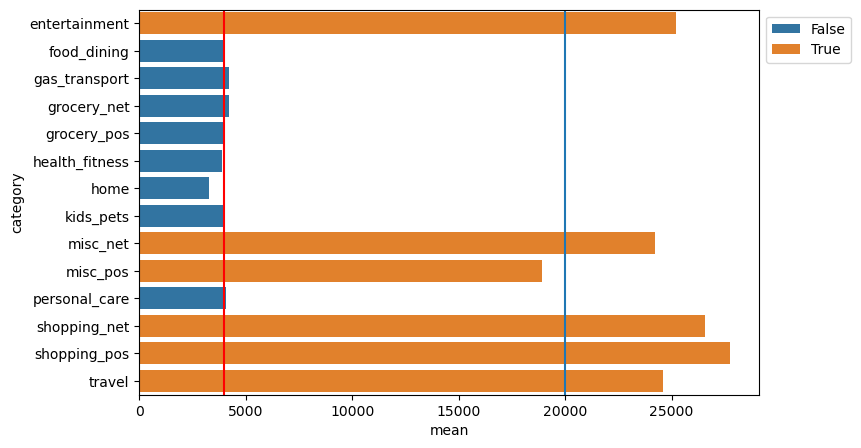

In [347]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=other_rules_merge, x="mean", y="category", hue="extreme_amount", ax=ax)
ax.legend(bbox_to_anchor=(1, 1))
ax.axvline(20000)
ax.axvline(4000, color="r");

**Суммы `trans_freq_increase`**
- должно быть согласно таким параметрам min=2000, max=10000, mean=4000

In [349]:
trans_freq_amts = fraud_purchase_test.query("rule == 'trans_freq_increase'").groupby(["category"], as_index=False) \
                                        .agg({"amount":["min","max","mean","std"]}).round(2)
trans_freq_amts.head()

category  amount                          
                    min     max     mean      std
0   grocery_net  2020.0  9100.0  4305.16  1392.48
1      misc_net  2000.0  8700.0  4250.03  1316.73
2  shopping_net  2020.0  8350.0  4277.25  1292.16

**Сохранение `fraud_purchase_test` в файл**

In [351]:
fraud_purchase_test.to_parquet("./data/generated_data/fraud_purchase_test.parquet", engine="pyarrow")

# Добавление дропов

## Генерация счетов клиентов и внешних счетов

**Счета клиентов**  
Пускай начинаются с 10000

In [915]:
accounts = clients_with_geo[["client_id"]].copy()

In [916]:
accounts["account_id"] = 1

In [917]:
accounts.loc[0, "account_id"] = 10000

In [918]:
accounts.head()

,client_id,account_id
0,1,10000
1,2,1
2,3,1
3,4,1
4,5,1


In [919]:
# Кумулятивно складываем числа в серии. Получается в каждой записи будет результат сложения текущего и всех предыдущих чисел
# Т.е. 10000, 10000 + 1, 10001 + 1 и т.д. Так будут счета с номерами от 10000 до 10000 + n-1 клиентов

accounts["account_id"] = accounts["account_id"].cumsum()

In [920]:
accounts.head()

,client_id,account_id
0,1,10000
1,2,10001
2,3,10002
3,4,10003
4,5,10004


In [921]:
accounts.agg({"account_id":["min","max"]})

,account_id
min,10000
max,15368


In [923]:
assert accounts.shape[0] == accounts.account_id.nunique(), "Values in account_id are not unique!"
accounts.shape[0]

5369

In [926]:
# Колонка is_drop. Дроп клиент или нет. Пока нет дропов.
# Они будут обозначаться непосредственно во время генерации активности дропов

accounts["is_drop"] = False

In [927]:
accounts.head()

,client_id,account_id,is_drop
0,1,10000,False
1,2,10001,False
2,3,10002,False
3,4,10003,False
4,5,10004,False


**Внешние счета**  
Счета начинающиеся с максимального номера счета нашего клиента + 1

In [948]:
# Пусть будет 10000 счетов

start_id = accounts.account_id.max() + 1
outer_accounts = pd.Series(data=np.arange(start_id, start_id + 10000, step=1), name="account_id", dtype="int")

In [949]:
outer_accounts

0       15369
1       15370
2       15371
3       15372
4       15373
        ...  
9995    25364
9996    25365
9997    25366
9998    25367
9999    25368
Name: account_id, Length: 10000, dtype: int64

In [957]:
# Не должно быть пересечений по account_id

assert accounts.merge(outer_accounts, on="account_id").empty, "Clients account ids are in the outer account ids"

**Сохранение счетов в файлы**

In [961]:
accounts.to_csv("./data/generated_data/accounts.csv", index=False)

In [962]:
outer_accounts.to_csv("./data/generated_data/outer_accounts.csv", index=False)

## Класс `DropClient`
- метод get_account(self): Мб добавить вариант to_drop: bool. Перевод другому имеющемуся дропу. при этом. 
    - записываем счет дропа в свой счет. Атрибут account
    - записываем  счет дропа в атрибут drop_accounts
    - если надо перевести другому дропу, то фильтруем drop_accounts исключая свой
    - надо тогда клиентам приписать шестизначные счета. просто по порядку.
    - счета куда отправляют дропы это номера начинающиеся со счета последнего клиента + 1

In [1653]:
class DropClient:
    """
    Генератор сумм входящих/исходящих транзакций, сумм снятий, номеров счетов.
    Управление балансом текущего дропа.
    """
    def __init__(self, accounts, account, outer_accounts, balance=0, batch_txns=0, chunk_size=0, used_accounts=pd.Series(name="account_id")):
        """
        accounts - pd.DataFrame. Счета клиентов банка.
        account - int. Номер счета текущего дропа.
        outer_accounts - pd.Series. Номера счетов для входящих и исходящих переводов в/из других банков.
        balance - float. Текущий баланс дропа
        batch_txns - int. Счетчик транзакций сделанных в рамках распределения полученной партии денег
        chunk_size - int, float. Последний созданный размер части баланса для перевода по частям.
        used_accounts - pd.Series. Счета на которые дропы уже отправляли деньги.
        """
        self.accounts = accounts
        self.account = account
        self.outer_accounts = outer_accounts
        self.balance = balance
        self.batch_txns = batch_txns
        self.chunk_size = chunk_size
        self.used_accounts = used_accounts

    def update_balance(self, amount, add=False, declined=False):
        """
        Увеличить/уменьшить баланс на указанную сумму
        -------------------
        amount - float, int.
        add - bool. Прибавлять сумму или отнимать.
        declined - bool. Отклонена ли транзакция или одобрена.
        """
        # Не обновлять баланс если транзакция отклонена.
        if declined:
            return
            
        # Увеличить баланс   
        if add:
            self.balance += amount
            return
            
        # Уменьшить баланс    
        self.balance -= amount

    def receive(self, declined, low=5000, high=100000, mean=30000, std=20000, round=500):
        """
        Генерация суммы входящего перевода
        --------------------------
        declined - bool. Отклонена ли транзакция или одобрена
        low - float. Минимальная сумма
        high - float. Максимальная сумма
        mean - float. Средняя сумма
        std - float. Стандартное отклонение
        round - int. Округление целой части. По умолчанию 500. Значит числа будут либо с 500 либо с 000 на конце
                     При условии что round не больше low и high. Чтобы отменить округление, нужно выставить 1
        """

        # Генерация суммы. Округление целой части при необходимости
        amount = get_values_from_truncnorm(low_bound=low, high_bound=high, mean=mean, std=std)[0] // round * round
        
        # Обновляем баланс если транзакция не отклонена
        self.update_balance(amount=amount, add=True, declined=declined)
        
        return amount

    def get_chunk_size(self, online=False, atm_min=10000, atm_share=0.5, round=500, start=0, stop=0, step=0):
        """
        Вернуть случайный размер суммы перевода для перевода по частям
        либо вернуть долю от баланса для снятия/перевода по частям.
        -------------------------------
        online - bool. Онлайн или оффлайн. Перевод или банкомат. Если банкомат, то снимается доля atm_share от баланса, но не меньше atm_min
        atm_min - int, float. Минимальная сумма снятия дропом в банкомате.
        atm_share - float. Доля от баланса если снятие через банкомат.
        round - int. Округление целой части. По умолчанию 500. 
                     Значит суммы будут округлены до тысяч или пяти сотен
        start - int. Минимальный размер. Прописываем если генерация не через share.
                     То же самое для stop и step
        stop - int. Максимальный размер - не входит в возможный выбор.
                    Максимальное генерируемое значение равно stop - step
        step - int. Шаг размеров.
        --------------------
        Возвращает np.int64
        Результат кэшируется в self.chunk_size
        """
        # Если это не первая транзакция в серии транзакции для одной полученной дропом суммы
        # То просто возвращаем ранее созданный размер чанка
        if self.batch_txns != 0:
            return self.chunk_size

        # Если перевод
        if online:
            sampling_array = np.arange(start, stop, step)
            self.chunk_size = np.random.choice(sampling_array)
            return self.chunk_size
            
        # Если снятие    
        self.chunk_size = max(atm_min, self.balance * atm_share // round * round)
        return self.chunk_size
            
        
    def one_operation(self, amount=0, declined=False, in_chunks=False):
        """
        Генерация суммы операции дропа.
        ---------
        amount - float, int. Сумма перевода если перевод по частям - in_chunks == True
        declined - bool. Отклонена ли транзакция или одобрена
        in_chunks - bool. Перевод по частям или целиком. Если False, то просто пробуем перевести все с баланса
                          При True нужно указать amount.
        """
        if in_chunks and amount <= 0:
            raise ValueError(f"""If in_chunks is True, then amount must be greater than 0.
Passed amount: {amount}""")

        # Если перевод не по частям. Пробуем перевестит все с баланса. 
        if not in_chunks:
            amount = self.balance
            self.update_balance(amount=self.balance, add=False, declined=declined)
            # Прибавляем счетчик транзакции для текущей партии денег
            self.batch_txns += 1
            return amount

        # Иначе считаем сколько частей исходя из размера одной части
        chunks = self.balance // amount

        # Если целое число частей больше 0. Пробуем перевести одну часть
        if chunks > 0:
            self.update_balance(amount=amount, add=False, declined=declined)
            self.batch_txns += 1
            return amount

        # Если баланс меньше одной части. Пробуем перевести то что осталось
        rest = self.balance
        self.update_balance(amount=rest, add=False, declined=declined)
        self.batch_txns += 1
        return rest

    def get_account(self, to_drop):
        """
        Номер счета входящего/исходящего перевода
        to_drop - bool. Перевод другому дропу в нашем банке или нет.
        """
        # Фильтруем accounts исключая свой счет и выбирая дропов. Для случая если to_drop
        drop_accounts = self.accounts.loc[(self.accounts.account_id != self.account) & (self.accounts.is_drop == True)]

        # Если надо отправить другому дропу в нашем банке. При условии что есть другие дропы на текущий момент
        if to_drop and not drop_accounts.empty: 
            account = drop_accounts.account_id.sample(1).iat[0]
            # Добавляем этот счет в использованные как последнюю запись в серии
            self.used_accounts.loc[self.used_accounts.shape[0]] = account
            return account

        # Если отправляем/получаем из другого банка.  
        # Семплируем номер внешнего счета который еще не использовался
        account = self.outer_accounts.loc[~(self.outer_accounts.isin(self.used_accounts))].sample(1).iat[0]
        # Добавляем этот счет в использованные как последнюю запись в серии
        self.used_accounts.loc[self.used_accounts.shape[0]] = account
        
        return account

    def reset_cache(self, balance=True, used_accounts=True, chunk_size=True, batch_txns=True):
        """
        Сброс кэшированных значений
        По умолчанию сбрасывается всё. Если что-то надо оставить, то надо выставить False
        для этого
        -----------------
        balance - bool
        used_accounts - bool
        chunk_size - bool
        batch_txns - bool
        """
        if balance:
            self.balance = 0
        if used_accounts:
            self.used_accounts = pd.Series(name="account_id")
        if chunk_size:
            self.chunk_size = 0
        if batch_txns:
            self.batch_txns = 0

In [1654]:
drop_client_test = DropClient(accounts=accounts, account=1, outer_accounts=outer_accounts)

In [1575]:
drop_client_test.receive(declined=True)

np.float64(31500.0)

In [1584]:
drop_client_test.balance

0

In [1655]:
drop_client_test.receive(declined=False)

np.float64(34500.0)

In [1286]:
drop_client_test.reset_balance()
drop_client_test.update_balance(amount=15000, add=True)
drop_client_test.balance

15000

In [1639]:
drop_client_test.batch_txns = 0
# Проверка что размер чанка меняется если batch_txns равно нулю
[drop_client_test.get_chunk_size(online=True, atm_min=10000, atm_share=0.5, round=500, start=5000, stop=25000, step=5000) for _ in range(10)]

[np.int64(15000),
 np.int64(10000),
 np.int64(20000),
 np.int64(20000),
 np.int64(20000),
 np.int64(20000),
 np.int64(20000),
 np.int64(10000),
 np.int64(10000),
 np.int64(10000)]

In [1640]:
# Проверка что размер чанка не меняется если batch_txns не равно нулю
drop_client_test.batch_txns = 1
[drop_client_test.get_chunk_size(online=True, atm_min=10000, atm_share=0.5, round=500, start=5000, stop=25000, step=5000) for _ in range(10)]

[np.int64(10000),
 np.int64(10000),
 np.int64(10000),
 np.int64(10000),
 np.int64(10000),
 np.int64(10000),
 np.int64(10000),
 np.int64(10000),
 np.int64(10000),
 np.int64(10000)]

In [1602]:
drop_client_test.get_account(to_drop=False)

np.int64(22956)

In [1604]:
drop_client_test.used_accounts, drop_client_test.chunk_size, drop_client_test.balance

(0    22956
 Name: account_id, dtype: int64,
 np.int64(20000),
 np.float64(15000.0))

In [1605]:
drop_client_test.reset_cache()

In [1606]:
drop_client_test.used_accounts, drop_client_test.chunk_size, drop_client_test.balance

(Series([], Name: account_id, dtype: object), 0, 0)

In [1115]:
drop_client_test.update_balance(amount=7500)
drop_client_test.balance

np.float64(60000.0)

In [1116]:
drop_client_test.update_balance(amount=9900, add=True)
drop_client_test.balance

np.float64(69900.0)

In [1656]:
chunk_size = drop_client_test.get_chunk_size(start=5000, stop=25000, step=5000)
chunk_size

np.float64(17000.0)

In [1233]:
chunk_size = drop_client_test.get_chunk_size(share=0.25)
chunk_size

np.float64(8000.0)

In [1658]:
drop_client_test.one_operation(amount=chunk_size, declined=False, in_chunks=True)

np.float64(17000.0)

In [1659]:
drop_client_test.balance, drop_client_test.batch_txns

(np.float64(17500.0), 1)

In [1236]:
drop_client_test.one_operation(amount=chunk_size, share=1, declined=True, in_chunks=True)
drop_client_test.balance

np.float64(25000.0)

In [1237]:
drop_client_test.one_operation(amount=0, share=1, declined=True, in_chunks=False)
drop_client_test.balance

np.float64(25000.0)

In [1243]:
drop_client_test.receive(declined=False, low=100000, high=500000, mean=250000, std=150000, round=1000)
drop_client_test.balance

np.float64(152000.0)

In [ ]:
drop_client_test.balance

In [1239]:
drop_client_test.one_operation(amount=0, share=0.5, declined=False, in_chunks=True)
drop_client_test.balance

np.float64(0.0)

In [1153]:
drop_client_test.balance

np.float64(38500.0)

In [1166]:
drop_client_test.transfer(declined=True, in_chunks=False)

np.float64(38500.0)

In [1167]:
drop_client_test.balance

np.float64(38500.0)

In [1242]:
drop_client_test.reset_balance()

np.float64(186491.0)

In [1180]:
drop_client_test.atm(share=0.5, declined=False)

np.float64(93000.0)

In [1181]:
drop_client_test.balance

np.float64(93491.0)

In [1009]:
chunk_size = drop_client_test.get_chunk_size(start=5000, stop=25000, step=5000)
chunk_size

np.int64(15000)

In [1011]:
# drop_client_test.transfer(batch=3, chunk_size=chunk_size)

np.int64(15000)

In [1012]:
drop_client_test.balance

np.float64(43141.0)

In [1013]:
# drop_client_test.transfer(batch=3, chunk_size=chunk_size)
# drop_client_test.transfer(batch=3, chunk_size=chunk_size)
# drop_client_test.transfer(batch=3, chunk_size=chunk_size)

np.float64(13141.0)

In [1014]:
drop_client_test.balance

0

In [1015]:
# drop_client_test.receive(batch=4)

np.float64(26000.0)

In [1016]:
# drop_client_test.reset_balance()
# drop_client_test.balance

0

**тест `get_account`**

In [1292]:
test_accounts = accounts.sample(1000).copy()

In [1293]:
# Сделаем 10 процентов дропами для тестов

for client in test_accounts.itertuples():
    if np.random.uniform(0, 1) < 0.101:
        test_accounts.loc[client.Index, "is_drop"] = True

In [1294]:
test_accounts["is_drop"].value_counts(normalize=True)

is_drop
False    0.894
True     0.106
Name: proportion, dtype: float64

In [1295]:
test_acc = test_accounts.account_id.sample(1, random_state=33).iat[0]

drop_cl_test_accs = DropClient(accounts=test_accounts, account=test_acc, outer_accounts=outer_accounts)

In [1296]:
test_accounts.account_id.sample(1, random_state=33)

4707    14707
Name: account_id, dtype: int64

In [1297]:
drop_cl_test_accs.get_account(to_drop=False)

np.int64(24381)

In [1298]:
drop_cl_test_accs.used_accounts

0    24381
Name: account_id, dtype: int64

In [1299]:
drop_to = drop_cl_test_accs.get_account(to_drop=True)
drop_to

np.int64(11233)

In [1300]:
test_accounts.loc[test_accounts.account_id == drop_to]

,client_id,account_id,is_drop
1233,1295,11233,True


In [1301]:
drop_cl_test_accs.used_accounts

0    24381
1    11233
Name: account_id, dtype: int64

In [1302]:
drop_cl_test_accs.balance

0

-9417

## Класс `CreateDropTxn`

In [1793]:
class CreateDropTxn:
    """
    Создание транзакций дропа под разное поведение.
    """
    def __init__(self, timestamps, trans_partial_data, drop_client_cls, in_txns=0, out_txns=0, in_lim=6, out_lim=8, last_txn={}, \
                attempts=0):
        """
        timestamps - pd.DataFrame.
        trans_partial_data - FraudTransPartialData. Генератор части данных транзакции - мерчант, гео, ip, девайс и т.п.
        drop_client_cls - DropClient. Генератор активности дропов: суммы, счета, баланс
        in_txns - int. Количество входящих транзакций
        out_txns - int. Количество исходящих транзакций
        in_lim - int. Лимит входящих транзакций. Транзакции клиента совершенные после достижения этого лимита отклоняются
        out_lim - int. Лимит исходящих транзакций. Транзакции клиента совершенные после достижения этого лимита отклоняются
        last_txn - dict. Полные данные последней транзакции
        attempts - int. Сколько попыток совершить операцию будет сделано дропом после первой отклоненной транзакции.
        """
        self.timestamps = timestamps
        self.trans_partial_data = trans_partial_data
        self.drop_client = drop_client_cls
        self.in_txns = in_txns
        self.out_txns = out_txns
        self.in_lim = in_lim
        self.out_lim = out_lim
        self.last_txn = last_txn
        self.attempts = attempts

    def get_time_delta(self, min=-180, max=180, minutes=True):
        """
        Получение случайного интервала времени в секундах или минутах из равномерного распределения
        ---------------------
        min - int. Минимальное возможное значение
        max - int. Максимальное возможное значение
        minutes - bool. Минуты или секунды
        """
        if minutes:
            return round(np.random.uniform(min, max))
            
        return round(np.random.uniform(min, max) * 60)

    def get_txn_time(self, in_lim=2, out_lim=5, lag_interval=1440):
        """
        Генерация времени транзакции
        ------------------
        in_lim - int. Количество входящих транзакций после которых дроп уходит на паузу указанную в lag_interval
                      Т.е. если на момент генерации времени уже сделано in_lim транзакций, то берется время последней
                      транзакции и прибавляется указанный lag_interval +/- случайное число минут из delta.
        out_lim - int. Количество исходящих транзакций после которых дроп уходит на паузу указанную в lag_interval
        lag_interval - int. Желаемый лаг по времени от последней транзакции в минутах.
                            Используется для перерывов в активности дропа. По умолчанию 1440 минут т.е. 24 часа
        """
        # Если это первая транзакция. Т.к. активность дропа начинается с входящей транзакции
        if self.in_txns == 0:
            time_sample = self.timestamps.sample(1)
            txn_time = time_sample.timestamp.iat[0]
            txn_unix = time_sample.unix_time.iat[0]
            return txn_time, txn_unix

        # Для последующих транзакций
        last_txn_unix = self.last_txn["unix_time"]

        # Если достигнуты лимиты активности дропа на период: входящих или исходящих транзакций
        if self.in_txns == in_lim or self.out_txns == out_lim:
            # Генерация дельты, чтобы время выглядело не ровным, а случайным.
            # Слагаем её с lag_interval
            time_delta = self.get_time_delta(min=-180, max=180)
            lag_interval += time_delta
            return derive_from_last_time(last_txn_unix=last_txn_unix, lag_interval=lag_interval)

        # Тоже дельта, но не может быть <= 0 т.к. тут мы ее используем как lag_interval
        # Это для случаев когда транзакция совершается в тот же период активности что и последняя
        time_delta = self.get_time_delta(min=30, max=180)
        

        return derive_from_last_time(last_txn_unix=last_txn_unix, lag_interval=time_delta)

    
    def stop_after_decline(self, declined):
        """
        Будет ли дроп пытаться еще после отклоненной операции
        или остановится
        ---------------
        declined - bool. Отклонена ли операция. Подразумевается что последняя.
        """
        if not declined:
            return
        
        if self.attempts == 0:
            return True

        if self.attempts > 0:
            return False

            
    def attempts_after_decline(self, min=0, max=4):
        """
        Определение количества попыток после первой отклоненной транзакции
        ---------------
        min - int. Минимальное число попыток
        max - int. Максимальное число попыток
        """
        self.attempts = np.random.randint(min, max)
            
        
    def deduct_attempts(self, declined, receive):
        """
        Вычитание попытки операции совершенной при статусе declined
        ---------------
        declined - bool. Отклоняется ли текущая транзакция
        receive - bool. Является ли транзакция входящей
        """
        if self.attempts == 0:
            return 
            
        if declined and not receive:
            self.attempts -= 1
            
        
    def single_operation(self, online, declined, in_chunks, to_drop_share=0.2, receive=False):
        """
        Один входящий/исходящий перевод либо одно снятие в банкомате.
        ---------------------
        online - bool. Онлайн перевод или снятие в банкомате.
        declined
        in_chunks
        to_drop_share - float. Вероятность, что дроп пошлет другому дропу
        receive - входящий перевод или нет.
        """
        client_id = self.trans_partial_data.client_info.client_id
        
        # Время транзакции. Оно должно быть создано до увеличения счетчика self.in_txns
        txn_time, txn_unix = self.get_txn_time(in_lim=2, out_lim=5, lag_interval=1440)

        if receive:
            self.in_txns += 1
            amount = self.drop_client.receive(declined=declined)
            account = self.drop_client.account
            
        elif not receive and online:
            to_drop = np.random.choice([True, False], p=[to_drop_share, 1 - to_drop_share])
            self.out_txns += 1
            account = self.drop_client.get_account(to_drop=to_drop)
            
        elif not receive and not online:
            account = self.drop_client.account
            self.out_txns += 1
        
            
        # Генерация части данных транзакции. Здесь прописываются аргументы online и receive
        merchant_id, trans_lat, trans_lon, trans_ip, trans_city, device_id, channel, type = \
                                                self.trans_partial_data.original_data(online=online, receive=receive)
        
        # Генерация суммы если исходящая транзакция
        # Если эта транзакция только часть серии операций для распределения всего баланса
        if in_chunks:
            chunk = self.drop_client.get_chunk_size(online=online, atm_min=10000, start=5000, stop=25000, step=5000)
            amount = self.drop_client.one_operation(amount=chunk, declined=declined, in_chunks=in_chunks)
            
        # Иначе если не по частям и не входящая транзакция
        elif not in_chunks and not receive:
            amount = self.drop_client.one_operation(declined=declined, in_chunks=in_chunks)

        
        if declined:
            status = "declined"
            is_fraud = True
            rule = "client_is_drop"
        else:
            status = "approved"
            is_fraud = False
            rule = "not applicable"

        # Статисчные характеристики
        is_suspicious = False
        category_name="not applicable"

        # Сборка всех данных в транзакцию и запись как послдней транзакции
        self.last_txn = build_transaction(client_id=client_id, txn_time=txn_time, txn_unix=txn_unix, amount=amount, type=type, channel=channel, \
                             category_name=category_name, online=online, merchant_id=merchant_id, trans_city=trans_city, \
                             trans_lat=trans_lat, trans_lon=trans_lon, trans_ip=trans_ip, device_id=device_id, account_to=account, \
                             is_fraud=is_fraud, is_suspicious=is_suspicious, status=status, rule=rule)

        return self.last_txn

    def limit_reached(self):
        """
        Проверка достижения лимитов входящих и исходящих транзакций
        Сверка с self.in_lim и self.out_lim
        ------------------------
        Вернет True если какой либо лимит достигнут
        """
        if self.in_lim == self.in_txns:
            return True
        if self.out_lim == self.out_txns:
            return True
        return False

    def reset_txn_counters(self, in_txns=False, out_txns=False, batch_txns=False):
        """
        Сброс счетчиков входящих и/или исходящих транзакций
        Партия денег это полученные деньги которые дроп должен распределить
        ------------------
        in_txns - bool. Сбросить счетчик входящих.
        out_txns - bool. Сбросить счетчик исходящих.
        batch_txns - bool. Сбросить счетчик транзакций партии денег.
        """
        if in_txns:
            self.in_txns = 0
        if out_txns:
            self.out_txns = 0
        if batch_txns:
            self.batch_txns = 0

    def reset_cache(self, only_counters=True):
        """
        Сброос кэшированных данных
        -------------
        only_counters - bool
                        Если True будут сброшены: self.in_txns, self.out_txns, self.attempts.
                        Если False то также сбросится информация о последней транзакции self.last_txn
        """
        
        self.in_txns = 0
        self.out_txns = 0
        self.attempts = 0

        if only_counters:
            return

        self.last_txn = {}

**`CreateDropTxn.single_operation` тест**

In [1312]:
drop_stamps = create_timestamps_range_df(start="2025-01-01", end="2025-01-31")

In [1728]:
drop_txn_part_data = FraudTransPartialData(merchants_df=pd.DataFrame(), client_info=clients_with_geo.loc[0], \
                                        online_merchant_ids=pd.DataFrame(), fraud_ips=fraud_ips, used_ips=pd.Series(), \
                                         fraud_devices=fraud_devices,  used_devices=pd.Series(), \
                                        client_devices=client_devices)

In [1729]:
# drop_txn_part_data.client_info

In [1730]:
drop_client_test2 = DropClient(accounts=accounts, account=1, outer_accounts=outer_accounts)

In [1731]:
create_drop_txn_tst = CreateDropTxn(timestamps=drop_stamps, trans_partial_data=drop_txn_part_data, drop_client_cls=drop_client_test2, \
                                      in_txns=0, out_txns=0, in_lim=6, out_lim=8, last_txn={}, attempts=0)

In [1732]:
create_drop_txn_tst.in_txns, create_drop_txn_tst.out_txns, create_drop_txn_tst.last_txn, drop_client_test2.batch_txns

(0, 0, {}, 0)

In [1342]:
# ?CreateDropTxn.single_operation

Входящая НЕотклоненная транзакция дропу

In [1691]:
create_drop_txn_tst.reset_cache(only_counters=False)
receive_txn = create_drop_txn_tst.single_operation(online=True, declined=False, in_chunks=False, receive=True)
pd.DataFrame([receive_txn])

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule
0,1,2025-01-10 05:15:00,1736486100,30000.0,inbound,transfer,not applicable,True,NaN,not applicable,NaN,NaN,not applicable,<NA>,1,False,False,approved,not applicable


In [1692]:
drop_client_test2.balance, drop_client_test2.batch_txns

(np.float64(30000.0), 0)

In [1693]:
create_drop_txn_tst.in_txns, create_drop_txn_tst.out_txns, create_drop_txn_tst.attempts

(1, 0, 0)

In [1542]:
# create_drop_txn_tst.last_txn

НЕ отклоненный исходящий перевод целиком

In [1694]:
whole_out = create_drop_txn_tst.single_operation(online=True, receive=False, declined=False, in_chunks=False)
pd.concat([pd.DataFrame([receive_txn]), pd.DataFrame([whole_out])], ignore_index=True)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule
0,1,2025-01-10 05:15:00,1736486100,30000.0,inbound,transfer,not applicable,True,NaN,not applicable,NaN,NaN,not applicable,<NA>,1,False,False,approved,not applicable
1,1,2025-01-10 05:47:00,1736488020,30000.0,outbound,transfer,not applicable,True,NaN,Рязань,54.625457,39.735999,2.60.0.1,2,20619,False,False,approved,not applicable


НЕ отклоненное снятие целиком

In [1712]:
create_drop_txn_tst.reset_cache(only_counters=False)
drop_client_test2.reset_cache(balance=True, used_accounts=True, chunk_size=True, batch_txns=True)
receive_txn2 = create_drop_txn_tst.single_operation(online=True, declined=False, in_chunks=False, receive=True)
whole_atm = create_drop_txn_tst.single_operation(online=False, receive=False, declined=False, in_chunks=False)

pd.concat([pd.DataFrame([receive_txn2]), pd.DataFrame([whole_atm])], ignore_index=True)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule
0,1,2025-01-18 22:50:00,1737240600,20000.0,inbound,transfer,not applicable,True,NaN,not applicable,NaN,NaN,not applicable,<NA>,1,False,False,approved,not applicable
1,1,2025-01-19 00:19:00,1737245940,20000.0,withdrawal,ATM,not applicable,False,NaN,Рязань,54.625457,39.735999,not applicable,<NA>,1,False,False,approved,not applicable


In [1713]:
drop_client_test2.balance, drop_client_test2.batch_txns

(np.float64(0.0), 1)

НЕ отклоненный исходящий перевод частями

In [1697]:
create_drop_txn_tst.reset_cache(only_counters=False)
drop_client_test2.reset_cache(balance=True, used_accounts=True, chunk_size=True, batch_txns=True)
receive_txn3 = create_drop_txn_tst.single_operation(online=True, declined=False, in_chunks=False, receive=True)
pd.DataFrame([receive_txn3])

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule
0,1,2025-01-04 16:02:00,1736006520,28000.0,inbound,transfer,not applicable,True,NaN,not applicable,NaN,NaN,not applicable,<NA>,1,False,False,approved,not applicable


In [1698]:
all_txns3 = [receive_txn3]
while drop_client_test2.balance > 0:
    part_out = create_drop_txn_tst.single_operation(online=True, receive=False, declined=False, in_chunks=True)
    all_txns3.append(part_out)
pd.DataFrame(all_txns3)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule
0,1,2025-01-04 16:02:00,1736006520,28000.0,inbound,transfer,not applicable,True,NaN,not applicable,NaN,NaN,not applicable,<NA>,1,False,False,approved,not applicable
1,1,2025-01-04 17:45:00,1736012700,20000.0,outbound,transfer,not applicable,True,NaN,Рязань,54.625457,39.735999,2.60.0.1,1,20964,False,False,approved,not applicable
2,1,2025-01-04 18:25:00,1736015100,8000.0,outbound,transfer,not applicable,True,NaN,Рязань,54.625457,39.735999,2.60.0.1,1,22372,False,False,approved,not applicable


In [1699]:
drop_client_test2.balance, drop_client_test2.batch_txns

(np.float64(0.0), 2)

НЕ отклоненное снятие частями

In [1700]:
create_drop_txn_tst.reset_cache(only_counters=False)
drop_client_test2.reset_cache(balance=True, used_accounts=True, chunk_size=True, batch_txns=True)
receive_txn4 = create_drop_txn_tst.single_operation(online=True, declined=False, in_chunks=False, receive=True)

all_txns4 = [receive_txn4]
while drop_client_test2.balance > 0:
    part_out = create_drop_txn_tst.single_operation(online=False, receive=False, declined=False, in_chunks=True)
    all_txns4.append(part_out)
pd.DataFrame(all_txns4)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule
0,1,2025-01-17 08:20:00,1737102000,45000.0,inbound,transfer,not applicable,True,NaN,not applicable,NaN,NaN,not applicable,<NA>,1,False,False,approved,not applicable
1,1,2025-01-17 10:35:00,1737110100,22500.0,withdrawal,ATM,not applicable,False,NaN,Рязань,54.625457,39.735999,not applicable,<NA>,1,False,False,approved,not applicable
2,1,2025-01-17 11:40:00,1737114000,22500.0,withdrawal,ATM,not applicable,False,NaN,Рязань,54.625457,39.735999,not applicable,<NA>,1,False,False,approved,not applicable


Отклоненный входящий перевод

In [1706]:
create_drop_txn_tst.reset_cache(only_counters=False)
drop_client_test2.reset_cache(balance=True, used_accounts=True, chunk_size=True, batch_txns=True)
receive_txn5 = create_drop_txn_tst.single_operation(online=True, receive=True, declined=True, in_chunks=False)
pd.DataFrame([receive_txn5])

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule
0,1,2025-01-01 07:56:00,1735718160,30000.0,inbound,transfer,not applicable,True,NaN,not applicable,NaN,NaN,not applicable,<NA>,1,True,False,declined,client_is_drop


In [1707]:
drop_client_test2.balance, drop_client_test2.batch_txns

(0, 0)

Отклоненный исходящий перевод целиком

In [ ]:
online=True, receive=False, declined=True, in_chunks=False

In [1710]:
create_drop_txn_tst.reset_cache(only_counters=False)
drop_client_test2.reset_cache(balance=True, used_accounts=True, chunk_size=True, batch_txns=True)
receive_txn6 = create_drop_txn_tst.single_operation(online=True, receive=True, declined=False, in_chunks=False)

whole_out2 = create_drop_txn_tst.single_operation(online=True, receive=False, declined=True, in_chunks=False)


pd.concat([pd.DataFrame([receive_txn6]), pd.DataFrame([whole_out2])], ignore_index=True)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule
0,1,2025-01-30 12:16:00,1738239360,25000.0,inbound,transfer,not applicable,True,NaN,not applicable,NaN,NaN,not applicable,<NA>,1,False,False,approved,not applicable
1,1,2025-01-30 14:51:00,1738248660,25000.0,outbound,transfer,not applicable,True,NaN,Рязань,54.625457,39.735999,2.60.0.1,1,17922,True,False,declined,client_is_drop


In [1711]:
drop_client_test2.balance, drop_client_test2.batch_txns

(np.float64(25000.0), 1)

**Отклоненное снятие целиком**

In [1781]:
create_drop_txn_tst.reset_cache(only_counters=False)
drop_client_test2.reset_cache(balance=True, used_accounts=True, chunk_size=True, batch_txns=True)
receive_txn7 = create_drop_txn_tst.single_operation(online=True, declined=False, in_chunks=False, receive=True)
whole_atm_2 = create_drop_txn_tst.single_operation(online=False, receive=False, declined=True, in_chunks=False)

pd.concat([pd.DataFrame([receive_txn7]), pd.DataFrame([whole_atm_2])], ignore_index=True)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule
0,1,2025-01-03 14:40:00,1735915200,29500.0,inbound,transfer,not applicable,True,NaN,not applicable,NaN,NaN,not applicable,<NA>,1,False,False,approved,not applicable
1,1,2025-01-03 15:42:00,1735918920,29500.0,withdrawal,ATM,not applicable,False,NaN,Рязань,54.625457,39.735999,not applicable,<NA>,1,True,False,declined,client_is_drop


In [1782]:
drop_client_test2.balance, drop_client_test2.batch_txns

(np.float64(29500.0), 1)

**Отклоненный  исходящий перевод частями**

In [1794]:
# Объявление новых объектов классов для тестов.
drop_txn_part_data = FraudTransPartialData(merchants_df=pd.DataFrame(), client_info=clients_with_geo.loc[0], \
                                        online_merchant_ids=pd.DataFrame(), fraud_ips=fraud_ips, used_ips=pd.Series(), \
                                         fraud_devices=fraud_devices,  used_devices=pd.Series(), \
                                        client_devices=client_devices)


drop_client_test2 = DropClient(accounts=accounts, account=1, outer_accounts=outer_accounts)

create_drop_txn_tst = CreateDropTxn(timestamps=drop_stamps, trans_partial_data=drop_txn_part_data, drop_client_cls=drop_client_test2, \
                                      in_txns=0, out_txns=0, in_lim=6, out_lim=8, last_txn={}, attempts=0)
create_drop_txn_tst.reset_cache(only_counters=False)
create_drop_txn_tst.in_txns, create_drop_txn_tst.out_txns, drop_client_test2.batch_txns, create_drop_txn_tst.limit_reached()

(0, 0, 0, False)

In [1795]:
create_drop_txn_tst.reset_cache(only_counters=False)
drop_client_test2.reset_cache(balance=True, used_accounts=True, chunk_size=True, batch_txns=True)
all_txns5 = []
declined=False
create_drop_txn_tst.attempts_after_decline(min=0, max=1)
drop_client_test2.chunk_size = 5000
drop_client_test2.batch_txns = 1

i = 1

while True:
    receive_txn8 = create_drop_txn_tst.single_operation(online=True, declined=declined, in_chunks=False, receive=True)
    all_txns5.append(receive_txn8)
    if declined:
        break
        
    while drop_client_test2.balance > 0:
        
        part_out = create_drop_txn_tst.single_operation(online=True, receive=False, declined=declined, in_chunks=True)
        all_txns5.append(part_out)
        print(f"iter {i}")
        create_drop_txn_tst.deduct_attempts(declined=declined, receive=False) 
        if create_drop_txn_tst.stop_after_decline(declined=declined):
            break
           
        declined = create_drop_txn_tst.limit_reached()
        i += 1
        
    # pd.DataFrame(all_txns5)

iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9


In [1798]:
pd.DataFrame(all_txns5)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule
0,1,2025-01-26 19:17:00,1737919020,9000.0,inbound,transfer,not applicable,True,NaN,not applicable,NaN,NaN,not applicable,<NA>,1,False,False,approved,not applicable
1,1,2025-01-26 19:54:00,1737921240,5000.0,outbound,transfer,not applicable,True,NaN,Рязань,54.625457,39.735999,2.60.0.1,2,17264,False,False,approved,not applicable
2,1,2025-01-26 22:17:00,1737929820,4000.0,outbound,transfer,not applicable,True,NaN,Рязань,54.625457,39.735999,2.60.0.1,2,18967,False,False,approved,not applicable
3,1,2025-01-26 23:24:00,1737933840,32500.0,inbound,transfer,not applicable,True,NaN,not applicable,NaN,NaN,not applicable,<NA>,1,False,False,approved,not applicable
4,1,2025-01-27 21:51:00,1738014660,5000.0,outbound,transfer,not applicable,True,NaN,Рязань,54.625457,39.735999,2.60.0.1,2,20290,False,False,approved,not applicable
5,1,2025-01-28 19:29:00,1738092540,5000.0,outbound,transfer,not applicable,True,NaN,Рязань,54.625457,39.735999,2.60.0.1,2,20575,False,False,approved,not applicable
6,1,2025-01-29 18:13:00,1738174380,5000.0,outbound,transfer,not applicable,True,NaN,Рязань,54.625457,39.735999,2.60.0.1,1,19220,False,False,approved,not applicable
7,1,2025-01-30 16:10:00,1738253400,5000.0,outbound,transfer,not applicable,True,NaN,Рязань,54.625457,39.735999,2.60.0.1,1,23528,False,False,approved,not applicable
8,1,2025-01-31 13:16:00,1738329360,5000.0,outbound,transfer,not applicable,True,NaN,Рязань,54.625457,39.735999,2.60.0.1,2,24752,False,False,approved,not applicable
9,1,2025-02-01 10:57:00,1738407420,5000.0,outbound,transfer,not applicable,True,NaN,Рязань,54.625457,39.735999,2.60.0.1,1,16527,False,False,approved,not applicable


np.float64(2500.0)

## Функция генерации транзакции дропа `gen_drop_txn`

In [1074]:
def one_batch_dist(drop_info, drop_client_act: DropClient, batch):
    """
    Распределение дропом одной партии полученных денег
    -------------------
    drop_info - namedtuples из itertuples(). Информация клиента-дропа из общего датафрейма клиентов
    drop_client_act - DropClient. Генератор атрибутов дропа и его действий; генератор счетов транзакций дропа
    batch - int. id партии денег полученной дропом.
    """
    amount_received = drop_client_act.received(batch=batch)
    scenario = np.random.choice(["atm-only", "transfer+atm", "transfer", "transfer_chunks"])
    for i in range(n):
        if i == 0:
            first = True
        else:
            first = False
        
        if scenario == "atm-only":
            atm_withdrawal()
            
        elif scenario == "atm+transfer":
            atm_withdrawal()

## Функция генерации активности дропа `drop_activity`

In [ ]:
def drop_activity(drop_info, drop_client_act: DropClient, lifetime):
    """
    drop_info - namedtuples из itertuples(). Информация клиента-дропа из общего датафрейма клиентов
    drop_client_act - DropClient. Генератор атрибутов дропа и его действий; генератор счетов транзакций дропа.
    lifetime - int. Сколько дней дроп будет проявлять активность, учитывая даже отклоненные транзакции
    """
    amount_received = drop_client_act.received(batch=)
    scenario = np.random.choice(["atm-only", "transfer+atm", "transfer", "transfer_chunks"])
    for i in range(n):
        if i == 0:
            first = True
        else:
            first = False
        
        if scenario == "atm-only":
            atm_withdrawal()
            
        elif scenario == "atm+transfer":
            atm_withdrawal()

In [1077]:
?DropClient.receive

Signature:
DropClient.receive(
    self,
    batch,
    low=5000,
    high=100000,
    mean=30000,
    std=20000,
    round=500,
)
Docstring:
Генерация суммы входящего перевода
--------------------------
batch - int. id текущей партии денег, которую он должен распределить (снять, перевести)
low - float. Минимальная сумма
high - float. Максимальная сумма
mean - float. Средняя сумма
std - float. Стандартное отклонение
round - int. Округление целой части. По умолчанию 500. Значит числа будут либо с 500 либо с 000 на конце.
             При условии что round не больше low и high. Чтобы отменить округление, нужно выставить 1.
File:      c:\users\iaros\appdata\local\temp\ipykernel_7648\484414114.py
Type:      function

## Функция генерации входящих/исходящих переводов дропов

In [ ]:
def drop_transfer(type, first, configs: ConfigForTrans, fraud_amount: TransAmount, \
                 trans_part_data: FraudTransPartialData, last_txn_unix, accounts, lag_interval=None) -> dict:
    
	if type == 'inbound':
		fraud_amount.transfer(type=type)
		fraud_amount.balance += amount
		trans_part_data.original_data(online=True)
        
	elif type == 'outbound':
		TransAmount.transfer(type=type)
		TransAmount.balance -= amount
		trans_part_data.original_data(online=True)

	if first:
        timestamp_sample = configs.timestamps.sample(1)
		txn_time = timestamp_sample.timestamp.iat[0]
        txn_unix = timestamp_sample.unix_time.iat[0]
	else:
		txn_time, txn_unix = derive_from_last_time(last_txn_unix=last_txn_unix, lag_interval=lag_interval)

    account = accounts.sample(1).iat[0]

	build_trans()


In [820]:
?get_time_for_trans

Signature:
get_time_for_trans(
    trans_df,
    is_fraud,
    time_weights,
    timestamps,
    timestamps_1st_month,
    round_clock,
    online=None,
    rule=None,
    geo_distance=None,
    lag=None,
)
Docstring:
trans_df - датафрейм с транзакциями текущего клиента. Откуда брать информацию по предыдущим транзакциям клиента
is_fraud - boolean. Фрод или не фрод
time_weights - датафрейм с весами часов в периоде времени
timestamps - датафрейм с timestamps
timestamps_1st_month - сабсет timestamps отфильтрованный по первому месяцу и, если применимо, году. Чтобы генерировать первые транзакции
round_clock - boolean. Круглосуточная или дневная категория.
online - boolean. Онлайн или оффлайн покупка. True or False
rule - str. Название антифрод правила
geo_distance - int. Дистанция между локацией последней и текущей транзакции если фрод со сменой геолокации - в километрах
lag - boolean. Задержка по времени от предыдущей транзакции. Нужна для моделирования увеличения частоты транзакций.
     

# Урезание количества клиентов - `отменено`
**Думаю просто можно равновероятно семплировать n клиентов и все, без ухищрений как внизу**  
Т.к. на ~5400 клиентов нужно очень много транзакций, чтобы у каждого их было хотя бы 50.  
Условно 270000 транзакций по 50 на 5400 клиентов. Скорее всего генерироваться будут больше часа

In [436]:
# на данный момент примерно до 800.

# clients_reduced_num = pd.DataFrame(districts_ru.clients.mul(0.15).round().astype("int"))
# clients_reduced_num["city"] = districts_ru["area"].copy()
# clients_reduced_num

# clients_reduced_df = gpd.GeoDataFrame(columns=clients_with_geo.columns)
# # clients_reduced_df.columns = 
# for col, data_type in clients_with_geo.dtypes.items():
#     # if data_type != "geometry" print(data_type)
#     clients_reduced_df[col] = clients_reduced_df[col].astype(f"{data_type}")
# # list(zip(clients_with_geo.dtypes.items(), clients_reduced_df.columns))
# clients_reduced_df.dtypes

# for row in clients_reduced_num.itertuples():
#     clients_with_geo_part = clients_with_geo.loc[clients_with_geo["area"] == row.city].iloc[0:row.clients]
#     clients_reduced_df = pd.concat([clients_reduced_df,clients_with_geo_part])

# clients_reduced_df

# Старый код, функции и т.д.

# Функция генерации весов для часов в периоде времени `get_time_for_trans` - Не модульная. Старая версия

In [ ]:
# def get_time_for_trans(trans_df, client_id, is_fraud, time_weights, timestamps, online=None, rule=None, geo_distance=None, lag=None):
#     """
#     trans_df - датафрейм с транзакциями. Откуда брать информацию по предыдущим транзакциям
#     client_id - id клиента, число, клиент чьи транзакции проверяются
#     is_fraud - boolean. Фрод или не фрод
#     time_weights - датафрейм с весами часов в периоде времени
#     timestamps - датафрейм с timestamps
#     online - boolean. Онлайн или оффлайн покупка. True or False
#     rule - строка. Название антифрод правила
#     geo_distance - число. Дистанция между локацией последней и текущей транзакции если фрод со сменой геолокации - в метрах
#     lag - boolean. Задержка по времени от предыдущей транзакции. Нужна для моделирования увеличения частоты транзакций.
#           Это задержка именно между последней легитимной транзакцией и серией частых транзакций. Подразумевается что функция
#           get_time_for_trans будет использована в цикле, и для первой итерации lag будет True.

#     Возвращает время для генерируемой транзакции в виде pd.Timestamp и в виде unix времени
#     """
    
#     # timestamp последней транзакции клиента - может быть вынести фильтрацию по client_id из функции?
#     # Хотя наверное и вне функции все равно надо будет каждый раз обновлять состояние перед генерацией новой транзакции
    
#     last_txn_time = trans_df[trans_df.client_id == client_id].txn_time.max()
#     last_txn_unix = trans_df[trans_df.client_id == client_id].unix_time.max()
    
#     # Если нет предыдущей транзакции т.е. нет последнего времени
#     if not is_fraud and last_txn_time is pd.NaT:
#         # берем первый год всего времененного периода т.к. это первая транзакция, пусть будет создана в первом году
#         timestamps_1st_year = timestamps.loc[timestamps.timestamp.dt.year == timestamps.timestamp.dt.year.min()]

#         # семплируем час из весов времени, указав веса для семплирования
#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         # фильтруем основной датафрейм с диапазоном таймстемпов по этому часу
#         timestamps_subset = timestamps_1st_year.loc[timestamps_1st_year.hour == txn_hour]
#         # из отфильтрованного датафрейма таймстемпов семплируем один таймстемп с равной вероятностью
#         txn_time = timestamps_subset.timestamp.sample(n=1, replace=True).iloc[0]
#         txn_unix = (txn_time - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

#     # Если есть предыдущая транзакция

#     # Не фрод. Но есть предыдущая транзакция
#     elif not is_fraud:

#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
#         timestamp_sample = timestamps_subset.sample(n=1, replace=True)
#         trans_time_diff = timestamp_sample.unix_time - last_txn_unix
#         pos_one_hour_diff = 3600
#         neg_one_hour_diff = -3600
        
#         # если время между текущей и последней транзакцией меньше часа в положительную сторону,
#         # то увеличим время чтобы разница была минимум час 
#         if trans_time_diff < pos_one_hour_diff and trans_time_diff >= 0:
#             time_addition = pos_one_hour_diff - trans_time_diff
#             txn_unix = txn_unix + time_addition
#             txn_time = pd.to_datetime(txn_unix, unit="s")
        
#         # если время между текущей и последней транзакцией меньше часа в отрицательную сторону, 
#         # то уменьшим время чтобы разница была минимум час
#         elif trans_time_diff > neg_one_hour_diff and trans_time_diff < 0:
#             time_subtraction = neg_one_hour_diff - trans_time_diff
#             txn_unix = txn_unix + time_subtraction
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Фрод. Правила: другая гео за короткое время либо по локации оффлайн мерчанта либо по новому ip адресу
#     elif is_fraud and rule in ["fast_geo_change", "fast_geo_change_online"]:
#         # Выставим порог скорости перемещения между точками транзакций - м/с
#         # выше порога - детект как фрода. 
#         # Это нужно чтобы генерировать соответствующее время в зависимости от дистанции между точками транзакций
#         # пусть будет порог в 800 км/ч. Делим на 3.6 для перевода в м/с
#         speed_threshold = 800 / 3.6
        
#         # Случайно сгенерированная фактическая скорость превышающая легитимный порог. Допустим от 801 до 36000 км/ч
#         # до 36000 км/ч т.к. грубо говоря транзакция может быть совершена через 20 минут в 9000 км от предыдущей т.е. как-будто бы скорость 36000 км/ч
#         # 9000 км взяты как весьма примерное, самое длинное возможное расстояние между городами России при путешествии самолетом.
#         # но в зависимости от расстояния мы берем разные границы для распределений, чтобы не было перекоса в очень быстрое время. 
#         # Также 20 минут я случайно взял как средний интервал для подобной фрод транзакции.
#         # Конечно же "скорость перемещения" может быть и больше в реальной жизни
        
#         if geo_distance < 1000_000:
#             fact_speed = random.randint(speed_threshold + 1, 3000) / 3.6
#         elif geo_distance >= 1000_000 and geo_distance <= 3000_000:
#             fact_speed = random.randint(speed_threshold + 1, 9000) / 3.6
#         elif geo_distance > 3000_000 and geo_distance <= 6000_000:
#             fact_speed = random.randint(speed_threshold + 1, 18000) / 3.6
#         else:
#             fact_speed = random.randint(speed_threshold + 1, 36000) / 3.6

#         # интервал времени между последней транзакцией и текущей фрод транзакцией
#         time_interval = geo_distance / fact_speed
        
#         txn_unix = last_txn_unix + time_interval
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Фрод. Увеличение количества транзакций в единицу времени выше установленного порога в процентах.
#     # генерируем время
#     elif is_fraud and rule == "trans_freq_increase":
#         # семплируем таймстемп из таймстемпов по времени не ранее последней транзакции
#         timestamp_sample = timestamps.loc[timestamps.timestamp > last_txn_time].sample(n=1, replace=True)
#         trans_time_diff = timestamp_sample.unix_time - last_txn_unix
#         lag_interval = 1800

#         # частота фрод транзакций. от 1 до 5 минут. Выразим в секундах для удобства
#         freq = random.randint(1, 5) * 60
        
#         # если транзакция первая в серии фрод транзакций - аргумент lag=True
#         # и интервал между последней транзакцией менее 30 минут
#         # прибавить интервал 30 минут к семплированному времени текущей транзакции
#         if lag and trans_time_diff < lag_interval:
#             txn_unix = timestamp_sample.unix_time + lag_interval
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#         # Если lag=True, но не надо добавлять интервал
#         elif lag:
#             txn_unix = timestamp_sample.unix_time
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#         # для остальных случаев - когда это не первые фрод транзакции в серии
#         else:
#             txn_unix = last_txn_unix + freq
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Любой другой фрод
#     elif is_fraud:

#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
#         timestamp_sample = timestamps_subset.sample(n=1, replace=True)

#         txn_unix = timestamp_sample.unix_time
#         txn_time = timestamp_sample.time

    
#     # время транзакции в виде timestamp и unix time
#     return txn_time, txn_unix
    

## Подфункция `ensure_min_interval_from_last_offline_trans` - когда есть предыдущие оффлайн транзакции и нужно обеспечить минимальный фиксированный интервал между транзакциями<br>
`Отменена`

In [ ]:
# def ensure_min_interval_from_last_offline_trans(last_txn_unix, timestamp_sample, time_diff=3600):
#     """
#     Обеспечивает минимальный фиксированный интервал от последней транзакции
#     -----------------------------------------------
#     last_txn_unix - unix время последней транзакции
#     timestamp_sample - случайно выбранная запись из датафрейма с таймстемпами
#     time_diff - желаемая минимальная разница от последней транзакции
    
#     Если сгенерированное время отличается от времени последней по времени транзакции на разницу меньше установленной
#     То вернет время с минимальной установленной разницей от последней транзакции.
#     Например либо час вперед либо час назад.
    
#     Если сгенерированное время раньше последней транзакции менее чем на time_diff, то вернет время последней транзакции минус time_diff.
#     Т.е. например на час раньше последней.
#     Если сгенерированное время позже последней транзакции менее чем на time_diff, то вернет время позже последней транзакции плюс time_diff.
#     Т.е. например на час позже последней.
#     Если разница в положительную либо в отрицательную сторону больше time_diff, то вернет исходное время без изменений.
#     """
    
#     timestamp_unix = timestamp_sample.unix_time.iloc[0]
#     trans_time_diff = timestamp_unix - last_txn_unix
#     pos_one_hour_diff = time_diff
#     neg_one_hour_diff = - time_diff
    
#     # если время между текущей и последней транзакцией меньше time_diff в положительную сторону,
#     # то увеличим время чтобы разница была минимум time_diff 
#     if trans_time_diff < pos_one_hour_diff and trans_time_diff >= 0:
#         print("Condition #1")
#         time_addition = pos_one_hour_diff - trans_time_diff
#         txn_unix = timestamp_unix + time_addition
#         txn_time = pd.to_datetime(txn_unix, unit="s")
    
#     # если время между текущей и последней транзакцией меньше time_diff в отрицательную сторону, 
#     # то уменьшим время чтобы разница была минимум time_diff
#     elif trans_time_diff > neg_one_hour_diff and trans_time_diff < 0:
#         print("Condition #2")
#         time_subtraction = neg_one_hour_diff - trans_time_diff
#         txn_unix = timestamp_unix + time_subtraction
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     # если разница во времени больше установленной
#     else:
#         txn_unix = timestamp_unix
#         txn_time = pd.to_datetime(txn_unix, unit="s")
        
        
#     return txn_time, txn_unix

In [ ]:
# def check_min_interval_from_near_trans(client_txns, timestamp_sample, online, offline_time_diff=60, \
#                                        online_time_diff=6, online_ceil=60, general_diff=30, general_ceil=90):
#     """
#     Если для сгенерированного времени есть транзакции, которые по времени ближе заданного минимума, 
#     то создать время на основании времени последней транзакции + установленный минимальный интервал.
#     Проверяет время либо для оффлайн либо для онлайн транзакций.
#     Для оффлайн и онлайн транзакций можно поставить свои минимальные интервалы.
#     Для онлайн ставится и максимальный интервал. Время берется случайно и равновероятно из диапазона между online_time_diff и online_ceil
#     -----------------------------------------------

#     client_txns - датафрейм с транзакциями клиента.
#     timestamp_sample - случайно выбранная запись из датафрейма с таймстемпами
#     offline_time_diff - int. желаемая минимальная разница от последней оффлайн транзакции в минутах
#     online_time_diff - int. желаемая минимальная разница от последней оффлайн транзакции в минутах
#     online_ceil - int. желаемая максимальная разница от последней оффлайн транзакции в минутах
#     general_diff - int. минимально допустимая разница от последней транзакции противоположной по флагу online.
#     general_ceil - int. максимальная разница от последней транзакции противоположной по флагу online.
#                    При случае необходимости увеличения разрыва времени.
#     """
    
#     timestamp_unix = timestamp_sample.unix_time.iloc[0]

#     offline_txns = client_txns.loc[client_txns.online == False]
#     online_txns = client_txns.loc[client_txns.online == True]
    
#     # смотрим ближайшие оффлайн и онлайн транзакции по времени по модулю.
#     # В переменные записываем время по модулю до ближайшей транзакции онлайн или оффлайн типа
#     closest_offline_txn = offline_txns.unix_time.sub(timestamp_unix).abs().min()
#     closest_online_txn = online_txns.unix_time.sub(timestamp_unix).abs().min()

#     # перевод аргументов в секунды для работы с unix time
#     offline_time_diff= offline_time_diff * 60
#     online_time_diff= online_time_diff * 60
#     online_ceil= online_ceil * 60
#     general_diff = general_diff * 60
#     general_ceil = general_ceil * 60
    
#     # Если текущая транзакция - оффлайн и разница с ближайшей транзакцией меньше допустимой
#     if not online and closest_txn_by_time < offline_time_diff:
        
#         # извлекаем время последней оффлайн транзакции и прибавляем установленный интервал
#         last_offline_txn_unix = offline_txns.unix_time.max()
#         txn_unix = last_offline_txn_unix + offline_time_diff
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Если текущая транзакция - онлайн и разница с ближайшей транзакцией меньше допустимой
#     elif online and closest_txn_by_time < online_time_diff:
        
#         # извлекаем время последней онлайн транзакции и прибавляем установленный интервал
#         last_online_txn_unix = online_txns.unix_time.max()

#         # Берем случайное время между online_time_diff и online_ceil
#         online_random_diff = random.randint(online_time_diff, online_ceil)

#         # прибавляем установленный интервал ко времени последней транзакции
#         txn_unix = last_online_txn_unix + online_random_diff
#         txn_time = pd.to_datetime(txn_unix, unit="s")
        
#     # если разница во времени является допустимой. Просто берем текущий timestamp
#     else:
#         txn_unix = timestamp_unix
#         txn_time = pd.to_datetime(txn_unix, unit="s")  
        
    
#     # Проверка есть ли слишком близкие по времени транзакции противоположные по флагу online
#     # Любая последняя транзакция. Если последняя транзакция такая же по флагу online, то разница
#     # Уже проверена и обеспечена в прошлом if-else блоке, и ничего не изменится.
#     last_txn_unix = client_txns.unix_time.max()
#     last_txn_diff = abs(last_txn_unix - txn_unix)
    
#     if last_txn_diff < general_diff:
#         general_random_diff = random.randint(general_diff, general_ceil)
#         txn_unix = last_txn_unix + general_random_diff
#         txn_time = pd.to_datetime(txn_unix, unit="s")
        
#     return txn_time, txn_unix

# Немодульная `get_time_for_trans` - старая версия

# `check_min_interval_from_near_trans` - до рефактора и добавления условий

In [ ]:
# def get_time_for_trans(trans_df, client_id, is_fraud, time_weights, timestamps, online=None, rule=None, geo_distance=None, lag=None):
#     """
#     trans_df - датафрейм с транзакциями. Откуда брать информацию по предыдущим транзакциям
#     client_id - id клиента, число, клиент чьи транзакции проверяются
#     is_fraud - boolean. Фрод или не фрод
#     time_weights - датафрейм с весами часов в периоде времени
#     timestamps - датафрейм с timestamps
#     online - boolean. Онлайн или оффлайн покупка. True or False
#     rule - строка. Название антифрод правила
#     geo_distance - число. Дистанция между локацией последней и текущей транзакции если фрод со сменой геолокации - в метрах
#     lag - boolean. Задержка по времени от предыдущей транзакции. Нужна для моделирования увеличения частоты транзакций.
#           Это задержка именно между последней легитимной транзакцией и серией частых транзакций. Подразумевается что функция
#           get_time_for_trans будет использована в цикле, и для первой итерации lag будет True.

#     Возвращает время для генерируемой транзакции в виде pd.Timestamp и в виде unix времени
#     """
    
#     # timestamp последней транзакции клиента - может быть вынести фильтрацию по client_id из функции?
#     # Хотя наверное и вне функции все равно надо будет каждый раз обновлять состояние перед генерацией новой транзакции
    
#     last_txn_time = trans_df[trans_df.client_id == client_id].txn_time.max()
#     last_txn_unix = trans_df[trans_df.client_id == client_id].unix_time.max()
    
#     # Если нет предыдущей транзакции т.е. нет последнего времени
#     if not is_fraud and last_txn_time is pd.NaT:
#         # берем первый год всего времененного периода т.к. это первая транзакция, пусть будет создана в первом году
#         timestamps_1st_year = timestamps.loc[timestamps.timestamp.dt.year == timestamps.timestamp.dt.year.min()]

#         # семплируем час из весов времени, указав веса для семплирования
#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         # фильтруем основной датафрейм с диапазоном таймстемпов по этому часу
#         timestamps_subset = timestamps_1st_year.loc[timestamps_1st_year.hour == txn_hour]
#         # из отфильтрованного датафрейма таймстемпов семплируем один таймстемп с равной вероятностью
#         txn_time = timestamps_subset.timestamp.sample(n=1, replace=True).iloc[0]
#         txn_unix = (txn_time - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

#     # Если есть предыдущая транзакция

#     # Не фрод. Но есть предыдущая транзакция
#     elif not is_fraud:

#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
#         timestamp_sample = timestamps_subset.sample(n=1, replace=True)
#         trans_time_diff = timestamp_sample.unix_time - last_txn_unix
#         pos_one_hour_diff = 3600
#         neg_one_hour_diff = -3600
        
#         # если время между текущей и последней транзакцией меньше часа в положительную сторону,
#         # то увеличим время чтобы разница была минимум час 
#         if trans_time_diff < pos_one_hour_diff and trans_time_diff >= 0:
#             time_addition = pos_one_hour_diff - trans_time_diff
#             txn_unix = txn_unix + time_addition
#             txn_time = pd.to_datetime(txn_unix, unit="s")
        
#         # если время между текущей и последней транзакцией меньше часа в отрицательную сторону, 
#         # то уменьшим время чтобы разница была минимум час
#         elif trans_time_diff > neg_one_hour_diff and trans_time_diff < 0:
#             time_subtraction = neg_one_hour_diff - trans_time_diff
#             txn_unix = txn_unix + time_subtraction
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Фрод. Правила: другая гео за короткое время либо по локации оффлайн мерчанта либо по новому ip адресу
#     elif is_fraud and rule in ["fast_geo_change", "fast_geo_change_online"]:
#         # Выставим порог скорости перемещения между точками транзакций - м/с
#         # выше порога - детект как фрода. 
#         # Это нужно чтобы генерировать соответствующее время в зависимости от дистанции между точками транзакций
#         # пусть будет порог в 800 км/ч. Делим на 3.6 для перевода в м/с
#         speed_threshold = 800 / 3.6
        
#         # Случайно сгенерированная фактическая скорость превышающая легитимный порог. Допустим от 801 до 36000 км/ч
#         # до 36000 км/ч т.к. грубо говоря транзакция может быть совершена через 20 минут в 9000 км от предыдущей т.е. как-будто бы скорость 36000 км/ч
#         # 9000 км взяты как весьма примерное, самое длинное возможное расстояние между городами России при путешествии самолетом.
#         # но в зависимости от расстояния мы берем разные границы для распределений, чтобы не было перекоса в очень быстрое время. 
#         # Также 20 минут я случайно взял как средний интервал для подобной фрод транзакции.
#         # Конечно же "скорость перемещения" может быть и больше в реальной жизни
        
#         if geo_distance < 1000_000:
#             fact_speed = random.randint(speed_threshold + 1, 3000) / 3.6
#         elif geo_distance >= 1000_000 and geo_distance <= 3000_000:
#             fact_speed = random.randint(speed_threshold + 1, 9000) / 3.6
#         elif geo_distance > 3000_000 and geo_distance <= 6000_000:
#             fact_speed = random.randint(speed_threshold + 1, 18000) / 3.6
#         else:
#             fact_speed = random.randint(speed_threshold + 1, 36000) / 3.6

#         # интервал времени между последней транзакцией и текущей фрод транзакцией
#         time_interval = geo_distance / fact_speed
        
#         txn_unix = last_txn_unix + time_interval
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Фрод. Увеличение количества транзакций в единицу времени выше установленного порога в процентах.
#     # генерируем время
#     elif is_fraud and rule == "trans_freq_increase":
#         # семплируем таймстемп из таймстемпов по времени не ранее последней транзакции
#         timestamp_sample = timestamps.loc[timestamps.timestamp > last_txn_time].sample(n=1, replace=True)
#         trans_time_diff = timestamp_sample.unix_time - last_txn_unix
#         lag_interval = 1800

#         # частота фрод транзакций. от 1 до 5 минут. Выразим в секундах для удобства
#         freq = random.randint(1, 5) * 60
        
#         # если транзакция первая в серии фрод транзакций - аргумент lag=True
#         # и интервал между последней транзакцией менее 30 минут
#         # прибавить интервал 30 минут к семплированному времени текущей транзакции
#         if lag and trans_time_diff < lag_interval:
#             txn_unix = timestamp_sample.unix_time + lag_interval
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#         # Если lag=True, но не надо добавлять интервал
#         elif lag:
#             txn_unix = timestamp_sample.unix_time
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#         # для остальных случаев - когда это не первые фрод транзакции в серии
#         else:
#             txn_unix = last_txn_unix + freq
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Любой другой фрод
#     elif is_fraud:

#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
#         timestamp_sample = timestamps_subset.sample(n=1, replace=True)

#         txn_unix = timestamp_sample.unix_time
#         txn_time = timestamp_sample.time

    
#     # время транзакции в виде timestamp и unix time
#     return txn_time, txn_unix
    

# Функция генератор одной легитимной POS транзакции `generate_one_legit_trans` - `первые тест сделаны` версия до рефактора

In [ ]:
# def generate_one_legit_trans(client_info, client_trans_df, category, merchants_df, online_merchant_ids, timestamps, \
#                              timestamps_1st_month, time_weights_dict):
#     """
#     Генерация одной легальной транзакции для клиента
#     ------------------------------------------------
#     client_info - namedtuple, полученная в результате итерации с помощью .itertuples() через датафрейм с информацией о клиентах
#     client_trans_df - датафрейм с транзакциями клиента.
#     category - датафрейм в одну запись с категорией и её характеристиками
#     merchants_df - датафрейм с оффлайн мерчантами заранее отфильтрованный по городу клиента т.к. это легальные транзакции
#     online_merchant_ids - id для онлайн мерчантов
#     time_weights_dict - веса для часов времени в виде словаря с: датафреймом с весами, названием распределения и цветом для графика
#     """

#     # Записываем данные клиента в переменные
#     client_id = client_info.client_id
#     client_area = client_info.area
#     client_area_lat = client_info.lat
#     client_area_lon = client_info.lon
#     client_ip = client_info.home_ip
    
    
#     # category = categories.sample(1, replace=True, weights=categories.share)
#     category_name = category["category"].iloc[0]
#     round_clock = category["round_clock"].iloc[0]
#     online = category["online"].iloc[0]
#     # средняя сумма для этой категории
#     amt_mean = category["avg_amt"].iloc[0]
#     # стандартное отклонение сумм для этой категории
#     amt_std = category["amt_std"].iloc[0]
    
#     # случайно сгенерированная сумма транзакции, но не менее 1
#     amount = max(1, np.random.normal(amt_mean, amt_std))

    
#     # 1. Offline_24h_Legit - круглосуточные оффлайн покупки
#     if not online and round_clock:
#         time_weights = time_weights_dict["Offline_24h_Legit"]["weights"]
#         merchant = merchants_df.loc[merchants_df.category == category_name].sample(1, replace=True)
#         merchant_id = merchant["merchant_id"].iloc[0]
#         trans_lat = merchant["merchant_lat"].iloc[0]
#         trans_lon = merchant["merchant_lon"].iloc[0]
#         status = "approved"
        
#         txn_time, txn_unix = get_time_for_trans(trans_df=client_trans_df, is_fraud=False, time_weights=time_weights, \
#                                                 timestamps=timestamps, timestamps_1st_month=timestamps_1st_month, \
#                                                 online=online)
#         pos_txn = {
#                     "client_id": client_id, "txn_time": txn_time, "unix_time":txn_unix, "amount": round(amount, 2), "type": "purchase",
#                     "channel": "POS", "category": category_name, "online": online, "merchant_id": merchant_id,
#                     "trans_city":client_area, "trans_lat": trans_lat, "trans_lon": trans_lon,"trans_ip":"not applicable",
#                     "account_to": np.nan, "is_fraud": False, "is_suspicious":False, "status":"approved",
#                     "rule":"not applicable"
#                     }


#     # 2. Online_Legit - Онлайн покупки
#     elif online:
#         time_weights = time_weights_dict["Online_Legit"]["weights"]
#         merchant_id = online_merchant_ids.sample(n=1).iloc[0]
#         # локация клиента по IP. Т.к. это не фрод. Просто записываем координаты города клиента
#         trans_lat = client_area_lat
#         trans_lon = client_area_lon
    
#         txn_time, txn_unix = get_time_for_trans(trans_df=client_trans_df, is_fraud=False, time_weights=time_weights, \
#                                                 timestamps=timestamps, timestamps_1st_month=timestamps_1st_month, \
#                                                 online=online)
#         pos_txn = {
#                     "client_id": client_id, "txn_time": txn_time, "unix_time":txn_unix, "amount": round(amount, 2), "type": "purchase",
#                     "channel": "POS", "category": category_name, "online": online, "merchant_id": merchant_id,
#                     "trans_city":client_area, "trans_lat": trans_lat, "trans_lon": trans_lon, "trans_ip":client_ip,
#                     "account_to": np.nan, "is_fraud": False, "is_suspicious":False, "status":"approved",
#                     "rule":"not applicable"
#                     }

#     # 3. Offline_Day_Legit - Оффлайн покупки. Дневные категории.
#     elif not online and not round_clock:
#         time_weights = time_weights_dict["Offline_Day_Legit"]["weights"]
#         merchant = merchants_df.loc[merchants_df.category == category_name].sample(1, replace=True)
#         merchant_id = merchant["merchant_id"].iloc[0]
#         trans_lat = merchant["merchant_lat"].iloc[0]
#         trans_lon = merchant["merchant_lon"].iloc[0]
#         status = "approved"
        
#         txn_time, txn_unix = get_time_for_trans(trans_df=client_trans_df, is_fraud=False, time_weights=time_weights, \
#                                                 timestamps=timestamps, timestamps_1st_month=timestamps_1st_month, \
#                                                 online=online)
#         pos_txn = {
#                     "client_id": client_id, "txn_time": txn_time, "unix_time":txn_unix, "amount": round(amount, 2), "type": "purchase",
#                     "channel": "POS", "category": category_name, "online": online, "merchant_id": merchant_id,
#                     "trans_city":client_area, "trans_lat": trans_lat, "trans_lon": trans_lon,"trans_ip":"not applicable",
#                     "account_to": np.nan, "is_fraud": False, "is_suspicious":False, "status":"approved",
#                     "rule":"not applicable"
#                     }


#     return pos_txn

# Основная функция генератор POS транзакций - изначальная. - старая, самая первая версия. До разбивки на легальные и фрод

In [ ]:
# Генерация POS транзакций
# def generate_legit_pos_transactions(client_info, start_date, end_date, time_weights_dict, categories, rules, trans_df, merchants_df, \
#                               area_centers, fraud_ips, online_merchant_ids, num=50, fraud_rate=0.01):
#     """
#     client_info  - датафрейм с данными клиента
#     start_date - первая транзакция
#     end_date - последняя транзакция
#     time_weights_dict - веса для часов времени в виде словаря с: датафреймом с весами, названием распределения и цветом для графика
#     categories - датафрейм с категориями и их характеристиками
#     rules -  датафрейм с антифрод правилами и их весами fraud_ips - датафрейм с фродовыми ip адресами
#     trans_df - датафрейм с транзакциями.
#                Куда их писать и куда обращаться за информацией по предыдущим транзакциям
#     merchants_df - датафрейм с оффлайн мерачантами
#     area_centers - названия городов с координатами центра
#     online_merchant_ids - id для онлайн мерчантов
#     num - количество транзакций на клиента
#     fraud_rate - доля фрода во всех транзакциях
#     """

#     # Датафрейм timestamp-ов откуда будет семплироваться время
#     timestamps = pd.DataFrame(pd.Series(pd.date_range(pd.to_datetime(start_date, format="%Y-%m-%d"), \
#                                                   pd.to_datetime(end_date, format="%Y-%m-%d"), freq='min'), name="timestamp"))
#     timestamps["hour"] = timestamps.timestamp.dt.hour
#     timestamps["unix_time"] = (timestamps.timestamp - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
#     # timestamps = pd.Series(pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='min'))
    
    



#     # итерируемся через уникальных клиентов
#     for row in client_info.itertuples():
#         pos_txns = [] # сюда временно будут добавляться созданные транзакции для текущего клиента

#         # данные клиента
#         client_id = row.client_id
#         client_area = row.area
#         client_area_geometry = row.geometry
#         client_ip = row.home_ip
        
#         # цикл создания n транзакций для текущего клиента
#         for _ in range(num):

#             # будет ли транзакция фродом или нет. Процент фрод транзакций зависит от выставленного fraud rate
#             is_fraud = random.random() < fraud_rate
            
#             #########################
#             # ЛЕГЕТИМНЫЕ ТРАНЗАКЦИИ #
#             #########################
#             if not is_fraud:
#                 # случайный выбор категории транзакции. В зависимости от частоты категории
#                 category = categories.sample(1, replace=True, weights=categories.share)
#                 category_name = category["category"].iloc[0]
#                 round_clock = category["round_clock"].iloc[0]
#                 online = category["online"].iloc[0]
#                 # средняя сумма для этой категории
#                 amt_mean = category["avg_amt"].iloc[0]
#                 # стандартное отклонение сумм для этой категории
#                 amt_std = category["amt_std"].iloc[0]
#                 # случайно сгенерированная сумма транзакции, но не менее 1
#                 amount = max(1, np.random.normal(amt_mean, amt_std))

#             # СТРОКА ДЛЯ ТЕСТОВ
#             # print(f"is_fraud:{is_fraud}, category_name: {category_name}")

            
#             # 1. Offline_24h_Legit - круглосуточные оффлайн покупки - НЕ фрод
#             if not is_fraud and not online and round_clock:
#                 time_weights = time_weights_dict["Offline_24h_Legit"]["weights"]
#                 merchant = merchants_df.loc[(merchants_df["area"] == client_area) & (merchants_df.category == category_name)].sample(1, replace=True)
#                 merchant_id = merchant["merchant_id"].iloc[0]
#                 trans_loc = merchant["geometry"].iloc[0]
#                 status = "approved"
                
#                 txn_time, txn_unix = get_time_for_trans(trans_df=trans_df, client_id=client_id, is_fraud=is_fraud, time_weights=time_weights, \
#                                                         timestamps=timestamps, online=False)
#                 pos_txns.append({
#                 "client_id": client_id, "txn_time": txn_time, "unix_time":txn_unix, "amount": round(amount, 2), "type": "purchase",
#                 "channel": "POS", "category": category_name, "online": online, "merchant_id": merchant_id,
#                 "trans_loc": trans_loc, "client_ip":"not applicable",
#                 "account_to": np.nan, "is_fraud": is_fraud, "status":"approved"
#             })


#             # 2. Online_Legit - Онлайн покупки - НЕ фрод
#             elif not is_fraud and online:
#                 time_weights = time_weights_dict["Online_Legit"]["weights"]
#                 merchant_id = online_merchant_ids.sample(n=1).iloc[0]
#                 # локация клиента по IP. Т.к. это не фрод. То просто ищем координаты города по городу клиента
#                 trans_loc = area_centers.loc[area_centers["area"] == client_area]

#                 txn_time, txn_unix = get_time_for_trans(trans_df=trans_df, client_id=client_id, is_fraud=is_fraud, time_weights=time_weights, \
#                                                         timestamps=timestamps, online=True)
#                 pos_txns.append({
#                 "client_id": client_id, "txn_time": txn_time, "unix_time":txn_unix, "amount": round(amount, 2), "type": "purchase",
#                 "channel": "POS", "category": category_name, "online": online, "merchant_id": merchant_id,
#                 "trans_loc": trans_loc, "client_ip":"not applicable",
#                 "account_to": np.nan, "is_fraud": is_fraud, "status":"approved"
#             })


            
#             #############################
#             # ГЕНЕРАЦИЯ ФРОД ТРАНЗАКЦИЙ #
#             #############################    

#             if is_fraud:
#                 # случайный выбор категории транзакции. В зависимости от частоты фрода в категории
#                 category = categories.sample(1, replace=True, weights=categories.fraud_share)
#                 category_name = category["category"].iloc[0]
#                 round_clock = category["round_clock"].iloc[0]
#                 online = category["online"].iloc[0]
#                 # средняя сумма для этой категории
#                 amt_mean = category["avg_amt"].iloc[0]
#                 # стандартное отклонение сумм для этой категории
#                 amt_std = category["amt_std"].iloc[0]
#                 # случайно сгенерированная сумма транзакции, но не менее 1
#                 # amount = max(1, np.random.normal(amt_mean, amt_std)) - amount для фрода генерится после определения правила


        
#         # Список словарей с готовыми транзакциями для одного клиента делаем геодатафреймом
#         # и присоединяем к основному геодатафрейму
#         trans_df_one_client = gpd.GeoDataFrame(pos_txns)
#         trans_df = pd.concat([trans_df, trans_df_one_client], ignore_index=True)

#     # Возвращаем целый датафрейм. Колонкой с геометрией устанавливаем trans_loc
#     return trans_df.set_geometry("trans_loc")

# Разбитая на подфункции функция `get_time_for_trans` - старая версия, до рефактора

In [ ]:
# def get_time_for_trans(trans_df, is_fraud, time_weights, timestamps, timestamps_1st_month, \
#                        online=None, rule=None, geo_distance=None, lag=None):
#     """
#     trans_df - датафрейм с транзакциями текущего клиента. Откуда брать информацию по предыдущим транзакциям клиента
#     is_fraud - boolean. Фрод или не фрод
#     time_weights - датафрейм с весами часов в периоде времени
#     timestamps - датафрейм с timestamps
#     timestamps_1st_month - сабсет timestamps отфильтрованный по первому месяцу и, если применимо, году. Чтобы генерировать первые транзакции
#     online - boolean. Онлайн или оффлайн покупка. True or False
#     rule - str. Название антифрод правила
#     geo_distance - int. Дистанция между локацией последней и текущей транзакции если фрод со сменой геолокации - в километрах
#     lag - boolean. Задержка по времени от предыдущей транзакции. Нужна для моделирования увеличения частоты транзакций.
#           Это задержка именно между последней легитимной транзакцией и серией частых фрод транзакций. Подразумевается что функция
#           get_time_for_trans будет использована в цикле, и для первой итерации lag будет True.

#     Возвращает время для генерируемой транзакции в виде pd.Timestamp и в виде unix времени
#     """
    
#     # timestamp последней транзакции клиента - может быть вынести фильтрацию по client_id из функции?
#     # Да. Вынесу фильтрацию по client_id из функции. Т.к. транзакции планируется генерировать в цикле итерируясь через клиентов.
    
#     last_txn_time = trans_df.txn_time.max()
#     last_txn_unix = trans_df.unix_time.max()
#     offline_txns = trans_df[trans_df.online == False]
#     online_txns = trans_df[trans_df.online == True]
    

#     ########################
#     # ЛЕГАЛЬНЫЕ ТРАНЗАКЦИИ #
#     ########################
    
#     # Если нет никакой предыдущей транзакции т.е. нет последнего времени совсем
#     if not is_fraud and last_txn_time is pd.NaT:
#         # берем первый месяц всего времененного периода т.к. это первая транзакция, пусть будет создана в первом месяце
#         # timestamps_1st_month = timestamps.loc[timestamps.timestamp.dt.month == timestamps.timestamp.dt.month.min()]

#         # получаем timestamp и unix время транзакции
#         txn_time, txn_unix = sample_time_for_trans(timestamps=timestamps_1st_month, time_weights=time_weights)

#         # время транзакции в виде timestamp и unix time. Здесь отдельный return, чтобы прервать дальнейшее выполнений функции
#         # т.к. это отдельный блок if-statements
#         return txn_time, txn_unix

    
#     # Если есть предыдущая транзакция

#     # берем случайный час передав веса часов
#     txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
    
#     # фильтруем по этому часу timestamp-ы и семплируем timestamp уже с равной вероятностью
#     timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
#     timestamp_sample = timestamps_subset.sample(n=1, replace=True)
        
#     # Не фрод. Текущая транзакция оффлайн и есть предыдущая оффлайн транзакция.
#     # Обеспечение минимального интервала времени между оффлайн транзакциями
#     # Это чтобы легальные транзакции не попали под фрод из-за частоты выполнения или быстроты физического перемещения клиента между транзакциями
    
#     if not is_fraud and not online and not offline_txns.empty:

#         # передаем функции сабсет из оффлайн транзакций, семплированный timestamp, онлайн ставим False, 
#         # минимально допустимая разница между другими оффлайн транзакциями - 60 минут
        
#         txn_time, txn_unix = check_min_interval_from_near_trans(txns_subset=offline_txns, timestamp_sample=timestamp_sample, online=False, \
#                                                                 offline_time_diff=60)

#     # Не фрод. Текущая транзакция онлайн и есть предыдущая онлайн транзакция.
#     # Обеспечение минимального интервала времени между онлайн транзакциями
    
#     elif not is_fraud and online and not online_txns.empty:
        
#         # передаем функции сабсет из оффлайн транзакций, семплированный timestamp, онлайн ставим True, 
#         # минимально допустимая разница между другими онлайн транзакциями - 6 минут
#         # разница от последней транзакции: от 6 до 60 минут - для случая если timestamp близко по времени к существующей транзакции
        
#         txn_time, txn_unix = check_min_interval_from_near_trans(txns_subset=offline_txns, timestamp_sample=timestamp_sample, online=False, \
#                                                                 online_time_diff=6, online_ceil=60)

#     # Случай когда есть любые предыдущие транзакции, но они другого типа: либо текущая категория онлайн, а предыдущие транзакции все оффлайн
#     # либо текущая категория оффлайн, а предыдущие транзакции все онлайн
#     elif not is_fraud:
#         # из отфильтрованного датафрейма таймстемпов семплируем один таймстемп с равной вероятностью
#         txn_time = timestamps_subset.timestamp.sample(n=1, replace=True).iloc[0]
#         txn_unix = pd_timestamp_to_unix(txn_time)
        

#     ########
#     # ФРОД #
#     ########

#     # Фрод. Правила: другая гео за короткое время либо по локации оффлайн мерчанта либо по новому ip адресу
#     elif is_fraud and rule in ["fast_geo_change", "fast_geo_change_online"]:
#         txn_time, txn_unix = generate_time_fast_geo_jump(last_txn_unix, geo_distance, threshold=800)

    
#     # Фрод. Увеличение количества транзакций в единицу времени выше установленного порога в процентах.
#     elif is_fraud and rule == "trans_freq_increase":
#         txn_time, txn_unix = gen_time_for_frequent_trans(last_txn_time, last_txn_unix, timestamps, time_weights, lag, \
#                                                          lag_interval=30, freq_low=1, freq_high=5)

#     # Фрод. Любое другое правило, где сабсет timestamp-ов семплирован ранее в соответствии с переданными весами
#     elif is_fraud:
#         # из отфильтрованного датафрейма таймстемпов семплируем один таймстемп с равной вероятностью
#         txn_time = timestamps_subset.timestamp.sample(n=1, replace=True).iloc[0]
#         txn_unix = pd_timestamp_to_unix(txn_time)


#     # время транзакции в виде timestamp и unix time
#     return txn_time, txn_unix

# Подфункция `check_min_interval_from_near_trans` - когда есть предыдущие транзакции - `Версия с багом`

In [ ]:
# def check_min_interval_from_near_trans(client_txns, timestamp_sample, online, round_clock, offline_time_diff=60, \
#                                        online_time_diff=6, online_ceil=60, general_diff=30, general_ceil=90, test=False):
#     """
#     Если для сгенерированного времени есть транзакции, которые по времени ближе заданного минимума, 
#     то создать время на основании времени последней транзакции + установленный минимальный интервал.
#     Учитывает разницу между типами транзакций: онлайн-онлайн, онлайн-оффлайн, оффлайн-оффлайн.
#     Можно поставить свои минимальные интервалы для случаев: онлайн-онлайн, онлайн-оффлайн, оффлайн-оффлайн. 
#     Для оффлайн-оффлайн - один фиксированный интервал.
#     Для онлайн-онлайн задается минимум и максимум откуда интервал берется с равной вероятностью
#     Для оффлайн-онлайн задается минимум и максимум откуда интервал берется с равной вероятностью
#     -----------------------------------------------

#     client_txns - датафрейм с транзакциями клиента.
#     timestamp_sample - случайно выбранная запись из датафрейма с таймстемпами
#     online - boolean. Онлайн или оффлайн категория
#     round_clock - boolean. Круглосуточная или дневная категория.
#     offline_time_diff - int. желаемая минимальная разница от последней оффлайн транзакции в минутах
#     online_time_diff - int. желаемая минимальная разница от последней оффлайн транзакции в минутах
#     online_ceil - int. желаемая максимальная разница от последней оффлайн транзакции в минутах
#     general_diff - int. минимально допустимая разница от последней транзакции противоположной по флагу online.
#     general_ceil - int. максимальная разница от последней транзакции противоположной по флагу online.
#                    При случае необходимости увеличения разрыва времени.
#     test - boolean. True - логировать исполнение функции в csv.
#     ------------------------------------------------
#     Возвращает pd.Timestamp и int unix время в секундах 
#     """

#     # перевод аргументов в секунды для работы с unix time
#     offline_time_diff= offline_time_diff * 60
#     online_time_diff= online_time_diff * 60
#     online_ceil= online_ceil * 60
#     general_diff = general_diff * 60
#     general_ceil = general_ceil * 60

    
#     timestamp_unix = timestamp_sample.unix_time.iloc[0]
#     # Копия, чтобы не внести изменения в исходный датафрейм
#     client_txns = client_txns.copy()
#     client_txns["abs_time_proximity"] = client_txns.unix_time.sub(timestamp_unix).abs()

#     # Запись о ближайшей по времени транзакции
#     closest_txn = client_txns.loc[client_txns.abs_time_proximity == client_txns.abs_time_proximity.min()]
#     # Онлайн или не онлайн ближайшая по времени транзакция
#     closest_online_flag = closest_txn.online.iloc[0]
#     # Разница семплированного timestamp-а с ближайшей по времени транзакцией
#     closest_time_diff = closest_txn.abs_time_proximity.iloc[0]

#     # Запись о последней транзакции
#     last_txn = client_txns.loc[client_txns.unix_time == client_txns.unix_time.max()]
#     # Онлайн или не онлайн последняя транзакция
#     last_online_flag = last_txn.online.iloc[0]
#     # unix время
#     last_txn_unix = last_txn.unix_time.iloc[0]
    
#     # Если, создаваемая транзакция оффлайн и ближайшая по времени тоже оффлайн
#     # И разница меньше допустимой
#     if not online and not closest_online_flag and closest_time_diff < offline_time_diff:
#         close_flag = "offline_to_offline"

#     # Если оффлайн транзакция и ближайшая онлайн. И разница меньше допустимой
#     elif not online and closest_online_flag and closest_time_diff < general_diff:
#         close_flag = "offline_to_online"
        
#     # Если, создаваемая транзакция онлайн и ближайшая по времени тоже онлайн
#     # И разница меньше допустимой
#     elif online and closest_online_flag and closest_time_diff < online_time_diff:
#         close_flag = "online_to_online"

#     # Если онлайн транзакция и ближайшая оффлайн. И разница меньше допустимой
#     elif online and not closest_online_flag and closest_time_diff < general_diff:
#         close_flag = "online_to_offline"
        
#     # Если нет транзакций ближе установленной разницы
#     # Просто берем изначальный timestamp
#     else:
#         close_flag = "No flag"
#         txn_unix = timestamp_unix
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Если транзакция близка по времени к другой, то согласно типам транзакций
#     # создаем другое время на основании времени и типа последней и текущей транзакции
#     if close_flag in ["offline_to_offline", "offline_to_online"]:
#         # Если последняя транзакция Онлайн. То добавляем случайную разницу для онлайн и оффлайн транзакций в установленном диапазоне
#         if last_online_flag:
#             general_random_diff = random.randint(general_diff, general_ceil)
#             txn_unix = last_txn_unix + general_random_diff
#             txn_time = pd.to_datetime(txn_unix, unit="s")
            
#         # Если последняя транзакция Оффлайн. То добавляем допустимую разницу между оффлайн транзакциями
#         elif not last_online_flag:
#             txn_unix = last_txn_unix + offline_time_diff
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Если текущая транзакция онлайн и есть онлайн/оффлайн транзакция с разницей меньше допустимой
#     elif close_flag in ["online_to_online", "online_to_offline"]:
#         # Если последняя транзакция онлайн. То добавляем случайную разницу для онлайн транзакций в установленном диапазоне
#         if last_online_flag:
#             online_random_diff = random.randint(online_time_diff, online_ceil)
#             txn_unix = last_txn_unix + online_random_diff
#             txn_time = pd.to_datetime(txn_unix, unit="s")
            
#         # Если последняя транзакция Оффлайн. То добавляем случайную разницу для онлайн и оффлайн транзакций в установленном диапазоне
#         elif not last_online_flag:
#             general_random_diff = random.randint(general_diff, general_ceil)
#             txn_unix = last_txn_unix + general_random_diff
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Проверка и корректировка времени, на случай если категория дневная, и время выходит за рамки этой категории
#     # Если час меньше 8 и больше 21. Т.е. ограничение 08:00-21:59
#     if not online and not round_clock and (txn_time.hour < 8 or txn_time.hour > 21):
#         txn_time = txn_time + pd.Timedelta(10, unit="h")
#         txn_unix = pd_timestamp_to_unix(txn_time)
        
#     if not test:
#         return txn_time, txn_unix
        
#     # В тестовом режиме логируем некоторые данные в csv
#     else:
#         log_check_min_time(client_id=client_txns.client_id.iloc[0], txn_time=txn_time, txn_unix=txn_unix, online=online, closest_txn=closest_txn, \
#                            closest_online_flag=closest_online_flag, last_txn=last_txn, last_online_flag=last_online_flag, close_flag=close_flag)
#         return txn_time, txn_unix

## Подфункция генерации времени транзакции для правила `trans_freq_increase` - timestamp семплируется `первая версия с lag`

In [327]:
# def gen_time_for_frequent_trans(last_txn_time, last_txn_unix, timestamps, time_weights, lag, lag_interval=30, \
#                                 freq_low=1, freq_high=5, test=False, test_timestamp=None):
#     """
#     Функция для имитации времени нескольких частых транзакций подряд.
#     -------------------------------------------------
#     last_txn_time - pd.Timestamp последней транзакции
#     last_txn_unix - unix время последней транзакции в секундах
#     timestamps - pd.DataFrame с диапазоном pd.Timestamp-ов и их unix аналогом в секундах и колонкой часа timestamp-а
#     lag - True или False. Является ли текущая транзакция первой в серии мошеннических/подозрительных учащенных транзакций.
#           При True будет добавлен лаг равный lag_interval от предыдущей легальной транзакции
#     lag_interval - int. лаг от предыдущей транзакции в минутах
#     freq_low - int. минимальный разрыв между транзакциями в цепочке фрод транзакций, в минутах
#     freq_high - int. максимальный разрыв между транзакциями в цепочке фрод транзакций, в минутах
#     test - True или False. Тестируем мы функцию или нет. Если тестируем, то надо передать test_timestamp
#     test_timestamp - str. Дата и время в формате '1899-01-01 00:00:00'. Это замена семплируемуго внутри
#                      функции timestamp-а, который проверяется на разницу во времени с последней легальной транзакцией.
#     --------------------------------------------------
#     При test == False возвращает pd.Timestamp и unix time в секундах
#     При test == True возвращает pd.Timestamp, unix time в секундах и получившуюся разницу времени с предыдущей транзакцией в минутах в виде int
#     """

#     # перевод минут в секунды для удобства подсчета с unix time
#     lag_interval = lag_interval * 60
    
#     # если транзакция первая в серии фрод транзакций - аргумент lag равен True. И не режим тестирования функции
#     if lag and not test:
        
#         # Фильтруем timestamp-ы, оставляя те, что после последней легитимной транзакции
#         timestamp_after_last_trans = timestamps.loc[timestamps.timestamp > last_txn_time]

#         # Семплируем час первой транзакции, передав веса часов.
#         # Затем фильтруем timestamp-ы по этому часу
#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         timestamps_subset = timestamp_after_last_trans.loc[timestamp_after_last_trans.hour == txn_hour]
#         # семплируем таймстемп из таймстемпов по времени не ранее последней транзакции
#         timestamp_sample = timestamps_subset.sample(n=1, replace=True)
#         # Узнаем разницу между timestamp-ом и последней транзакцией
#         trans_time_diff = timestamp_sample.unix_time.sub(last_txn_unix).iloc[0]

#     # Если режим тестирования. То timestamp_sample у нас это не семпл, а переданный в аргументе timestamp
#     elif lag and test:
#         timestamp_sample = pd.DataFrame({"timestamp":pd.Series(dtype="datetime64[s]"), "unix_time":pd.Series(dtype="int64")})
#         timestamp_sample.loc[0, "timestamp"] = pd.to_datetime(test_timestamp, format="%Y-%m-%d %H:%M:%S")
#         timestamp_sample.loc[0, "unix_time"] = pd_timestamp_to_unix(timestamp_sample.timestamp.iloc[0])
#         # Узнаем разницу между timestamp-ом и последней транзакцией
#         trans_time_diff = timestamp_sample.unix_time.iloc[0] - last_txn_unix


#     # если транзакция первая в серии фрод транзакций
#     # и интервал между последней транзакцией менее 30 минут
#     # прибавить интервал 30 минут к семплированному времени текущей транзакции
#     if lag and trans_time_diff < lag_interval:
#         # print("Condition #1")
#         time_addition = lag_interval - trans_time_diff
#         txn_unix = timestamp_sample.unix_time.iloc[0] + time_addition
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Если lag равен True, но не надо добавлять интервал
#     elif lag:
#         # print("Condition #2")
#         txn_unix = timestamp_sample.unix_time.iloc[0]
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     # для остальных случаев - когда это не первые фрод транзакции в серии
#     # просто добавляем 1-5 минут ко времени предыдущей транзакции
#     else:
#         # частота фрод транзакций. от 1 до 5 минут. Выразим в секундах для удобства расчетов
#         freq = random.randint(freq_low, freq_high) * 60
#         txn_unix = last_txn_unix + freq
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     if not test:
#         return txn_time, txn_unix
    
#     elif test and lag:
#         return txn_time, txn_unix
        
#     elif test and not lag:
#         return txn_time, txn_unix, freq

**Старые тесты `gen_time_for_frequent_trans`**

In [328]:
# weights_for_freq_trans = time_weights["Online_Fraud"]["weights"]

# Диапазон timestamp-ов для семплирования

# timestamps_freq_test = create_timestamps_range_df(start="2023-09-20", end="2023-09-21")

# # Датафрейм с последней транзакцией - перезапустить ячейку для теста ниже

# last_time = pd.to_datetime("2023-09-20 09:14:00", format="%Y-%m-%d %H:%M:%S")
# last_unix = pd_timestamp_to_unix(last_time)

# # условно основной датафрейм с транзакциями. У нас там одна легальная последняя транзакция на данный момент

# trans_test_freq_time = transactions.copy().loc[:, ['txn_time', 'unix_time','online','account_to', 'is_fraud', 'is_suspicious']]
# trans_test_freq_time.loc[0, ["txn_time","unix_time"]] = last_time, last_unix
# print(f"last_time, last_unix: {last_time, last_unix}")
# trans_test_freq_time

# # в этом скрипте нужно проверить с условиями:
# # 1. test_timestamp равен txn_time в исходном датафрейме с последней легальной транзакцией
# # 2. test_timestamp больше txn_time в исходном датафрейме с последней легальной транзакцией,на не более чем на 29 минут
# # 3. test_timestamp больше txn_time в исходном датафрейме с последней легальной транзакцией, на 30 и более минут

# trans_freq_temp_df = transactions.copy().loc[:, ['txn_time', 'unix_time','online','account_to', 'is_fraud', 'is_suspicious']]
# last_time = trans_test_freq_time.txn_time.max()
# last_unix = trans_test_freq_time.unix_time.max()

# test_mode = 3

# if test_mode == 1:
#     test_timestamp = last_time
# elif test_mode == 2:
#     test_timestamp = last_time + pd.Timedelta(7, unit="m")
# elif test_mode == 3:
#     test_timestamp = last_time + pd.Timedelta(30, unit="m")


# freq_values = []


# for i in range(1,6):
#     if i == 1:
#         lag = True

#         txn_time, txn_unix = gen_time_for_frequent_trans(last_txn_time=last_time, last_txn_unix=last_unix, timestamps=timestamps_freq_test, \
#                                                          time_weights=weights_for_freq_trans, lag=lag, \
#                                                          test=True, test_timestamp=test_timestamp)
        
#     else:
#         lag = False
    
#         txn_time, txn_unix, freq = gen_time_for_frequent_trans(last_txn_time=last_time, last_txn_unix=last_unix, timestamps=timestamps_freq_test, \
#                                                          time_weights=weights_for_freq_trans, lag=lag, \
#                                                          test=True, test_timestamp=test_timestamp)
#         freq_values.append(freq / 60)
        
#     trans_freq_temp_df.loc[i, "txn_time"] = txn_time
#     trans_freq_temp_df.loc[i, "unix_time"] = txn_unix
#     trans_freq_temp_df.loc[i, "is_fraud"] = True

    
#     last_time = txn_time
#     last_unix = txn_unix

# # средняя частота фрод транзакций - всех, кроме первой фрод транзакции
# print("\n\n Mean freq: ",pd.Series(freq_values).mean(), " minutes\n\n")

# # к последней легальной транзакции присоединяем сгенерированные частые транзакции
# trans_test_freq_time = pd.concat([trans_test_freq_time, trans_freq_temp_df])
# # разница во времени с предыдущей транзакцией, в минутах
# trans_test_freq_time["time_diff"] = trans_test_freq_time.unix_time.sub(trans_test_freq_time.unix_time.shift(1)) / 60
# trans_test_freq_time

In [329]:
# вторая запись. Первая фрод транзакция. time_diff должен быть не менее установленного lag_interval
# trans_test_freq_time.loc[1, "time_diff"]

# записи с третьей по последнюю - 2-я фрод транзакция и далее. time_diff должно быть в пределах диапазона freq
# trans_test_freq_time.loc[2:(trans_test_freq_time.shape[0] - 1)]

# txn_hour = time_weights["Offline_24h_Legit"]["weights"].hours.sample(n=1, \
#                                 weights=time_weights["Offline_24h_Legit"]["weights"].proportion, replace=True).iloc[0]
# timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
# timestamp_sample = timestamps_subset.sample(n=1, replace=True)

# last_time = pd.to_datetime("2024-07-24 19:26:00", format="%Y-%m-%d %H:%M:%S")
# last_unix = pd_timestamp_to_unix(last_time)
# last_time, last_unix